# Project 3 - Quantifying TV Laughter: A Data-Backed Guide for Brooklyn Nine-Nine and Big Bang Theory Investment

### Contents:
- [Background](#Background)
- [Scraping reddit using API](#Scraping-Reddit-using-API)
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
    - [Fine Tuning of Best Models](#Fine-Tuning-of-Best-Models)
- [Sentiment Analysis](#Sentiment-Analysis)

# Background

# Scraping reddit using API

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import random
import os
import ipywidgets as widgets
from IPython.display import display, HTML


# Import for string manipulations
import re
import string
import nltk

# Vectorization import
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Importing encoders
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
import gensim.utils

In [122]:
def scrape(subreddit_name, limit_val):
#     url = 'https://www.reddit.com/r/{}.json?t=hot'.format(subreddit_name)
#     url = 'https://www.reddit.com/r/{}/hot.json'.format(subreddit_name)
    url = 'https://www.reddit.com/r/{}.json'.format(subreddit_name)
    
    posts = []
    after = None
    
    # Setting file paths and folders to save the final dataframes in:
    # Construct the file path
    current_directory = os.getcwd()  # Get the current working directory
    target_directory = os.path.join(current_directory, '..', 'data')
    # Create the target directory if it doesn't exist
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    # Construct the file path within the target directory
    file_path = os.path.join(target_directory, '{}.csv'.format(subreddit_name))
    
    # Setting the number of reviews to scrape (Each scrape only gives 25 rows)
    range_val = int(limit_val/25)
    
    # Create a progress bar widget
    print(subreddit_name)
    progress_bar = widgets.IntProgress(min=0, max=range_val, value=0)
    display(progress_bar)
    
    for a in range(range_val):
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after
        res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})
        print(after)

        if res.status_code != 200:
            print('Status error', res.status_code)
            break

        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        after = current_dict['data']['after']

        if a > 0:
            prev_posts = pd.read_csv(file_path)
            current_df = pd.DataFrame(current_posts)
            combined = pd.concat([prev_posts, current_df])
            df = pd.DataFrame(combined)
            df.to_csv(file_path, index = False)

        else:
            df = pd.DataFrame(posts)
            df.to_csv(file_path, index = False)

        # generate a random sleep duration to look more 'natural'
        sleep_duration = random.randint(1,4)
        time.sleep(sleep_duration)

        # Update the progress bar value
        progress_bar.value = a+1

In [123]:
# Uncomment the following to scrape data again

# scrape('brooklynninenine', 2000)
# scrape('bigbangtheory', 2000)

# Data Import & Cleaning

### Preparing master dataframe `sitcom_df`

In [124]:
# Use df_multiple.csv for 100+ more rows of data

current_directory = os.getcwd()
file_path = os.path.join(current_directory, '../data/brooklynninenine_hot_full.csv')
df_b99 = pd.read_csv(file_path)
file_path = os.path.join(current_directory, '../data/bigbangtheory_hot_full.csv')
df_bbt = pd.read_csv(file_path)

df_b99.info()
display(df_b99.head())

df_bbt.info()
display(df_bbt.head())

# Preparing one final dataset to use for EDA
sitcom_df = pd.concat([df_bbt, df_b99]).reset_index(drop=True)
sitcom_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Columns: 114 entries, approved_at_utc to gallery_data
dtypes: bool(28), float64(25), int64(10), object(51)
memory usage: 688.9+ KB


approved_at_utc         subreddit                       selftext  \
0              NaN  brooklynninenine  Hi Mlepnos- I don't know you.   
1              NaN  brooklynninenine                            NaN   
2              NaN  brooklynninenine                            NaN   
3              NaN  brooklynninenine                            NaN   
4              NaN  brooklynninenine    Sorry for the poor quality.   

  author_fullname  saved  mod_reason_title  gilded  clicked  \
0     t2_cqeef7gs  False               NaN       0    False   
1     t2_vsxph4tc  False               NaN       0    False   
2     t2_8lvshkfv  False               NaN       0    False   
3        t2_qbybe  False               NaN       0    False   
4     t2_vieftcvf  False               NaN       0    False   

                                               title link_flair_richtext  ...  \
0                                        Mlepclaynos                  []  ...   
1  Brooklyn 99 Bingo! Watch episodes at random un...                  []  ...   
2                                     peraltiago irl                  []  ...   
3  Someone said they needed this, now. So enjoy m...                  []  ...   
4                              Reminds me someone...                  []  ...   

  stickied                                  url  subreddit_subscribers  \
0    False  https://i.redd.it/wttzr18y276b1.jpg                 731854   
1    False      https://i.imgur.com/081XqRP.jpg                 731854   
2    False  https://i.redd.it/wr3w8ez5496b1.jpg                 731854   
3    False  https://i.redd.it/pfdemmrz146b1.png                 731854   
4    False  https://i.redd.it/hqyrsqyl676b1.jpg                 731854   

    created_utc  num_crossposts  media  is_video  is_gallery media_metadata  \
0  1.686841e+09               0    NaN     False         NaN            NaN   
1  1.686840e+09               0    NaN     False         NaN            NaN   
2  1.686865e+09               0    NaN     False         NaN            NaN   
3  1.686804e+09               0    NaN     False         NaN            NaN   
4  1.686842e+09               0    NaN     False         NaN            NaN   

   gallery_data  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

[5 rows x 114 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Columns: 113 entries, approved_at_utc to author_cakeday
dtypes: bool(28), float64(26), int64(10), object(49)
memory usage: 682.5+ KB


approved_at_utc      subreddit  \
0              NaN  bigbangtheory   
1              NaN  bigbangtheory   
2              NaN  bigbangtheory   
3              NaN  bigbangtheory   
4              NaN  bigbangtheory   

                                            selftext author_fullname  saved  \
0  Hi all!  \nI made a The Big Bang Theory Discor...     t2_5fhfdvh8  False   
1                                                NaN       t2_10sfpj  False   
2                                                NaN     t2_36e33fdy  False   
3                                                NaN      t2_hl49fcs  False   
4  For me, it’s raj. Socially inept (especially w...     t2_u4u8uade  False   

   mod_reason_title  gilded  clicked  \
0               NaN       0    False   
1               NaN       0    False   
2               NaN       0    False   
3               NaN       0    False   
4               NaN       0    False   

                                               title  \
0       Official Discord Server for r/bigbangtheory!   
1  New 'Big Bang Theory' Spinoff in Development a...   
2  Why did Jim Parsons want to move on from the s...   
3                             Sing Soft Wookie To Me   
4  Anyone here relate to a certain character and ...   

                            link_flair_richtext  ... is_video  \
0                                            []  ...    False   
1                                            []  ...    False   
2  [{'e': 'text', 't': 'Character discussion'}]  ...    False   
3                  [{'e': 'text', 't': 'meme'}]  ...    False   
4                 [{'e': 'text', 't': 'Other'}]  ...    False   

                              url_overridden_by_dest  \
0                                                NaN   
1  https://variety.com/2023/tv/news/big-bang-theo...   
2                                                NaN   
3                https://i.redd.it/kmskyneum56b1.jpg   
4                                                NaN   

                 link_flair_template_id is_gallery  media_metadata  \
0                                   NaN        NaN             NaN   
1                                   NaN        NaN             NaN   
2  76df9848-a507-11ed-8500-f6aef49379c2        NaN             NaN   
3  5d4e9c3c-4a35-11eb-9184-0e809bd389b1        NaN             NaN   
4  0723b4f2-a508-11ed-a8d2-6a2e44a39017        NaN             NaN   

   gallery_data  crosspost_parent_list crosspost_parent  poll_data  \
0           NaN                    NaN              NaN        NaN   
1           NaN                    NaN              NaN        NaN   
2           NaN                    NaN              NaN        NaN   
3           NaN                    NaN              NaN        NaN   
4           NaN                    NaN              NaN        NaN   

  author_cakeday  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 113 columns]

approved_at_utc         subreddit  \
0                 NaN     bigbangtheory   
1                 NaN     bigbangtheory   
2                 NaN     bigbangtheory   
3                 NaN     bigbangtheory   
4                 NaN     bigbangtheory   
...               ...               ...   
1967              NaN  brooklynninenine   
1968              NaN  brooklynninenine   
1969              NaN  brooklynninenine   
1970              NaN  brooklynninenine   
1971              NaN  brooklynninenine   

                                               selftext author_fullname  \
0     Hi all!  \nI made a The Big Bang Theory Discor...     t2_5fhfdvh8   
1                                                   NaN       t2_10sfpj   
2                                                   NaN     t2_36e33fdy   
3                                                   NaN      t2_hl49fcs   
4     For me, it’s raj. Socially inept (especially w...     t2_u4u8uade   
...                                                 ...             ...   
1967                                                NaN        t2_t263l   
1968                                                NaN     t2_f7bjpzku   
1969                                                NaN     t2_577olepf   
1970                                                NaN       t2_13bfpx   
1971                                                NaN     t2_nwxvmcya   

      saved  mod_reason_title  gilded  clicked  \
0     False               NaN       0    False   
1     False               NaN       0    False   
2     False               NaN       0    False   
3     False               NaN       0    False   
4     False               NaN       0    False   
...     ...               ...     ...      ...   
1967  False               NaN       0    False   
1968  False               NaN       0    False   
1969  False               NaN       0    False   
1970  False               NaN       0    False   
1971  False               NaN       0    False   

                                                  title  \
0          Official Discord Server for r/bigbangtheory!   
1     New 'Big Bang Theory' Spinoff in Development a...   
2     Why did Jim Parsons want to move on from the s...   
3                                Sing Soft Wookie To Me   
4     Anyone here relate to a certain character and ...   
...                                                 ...   
1967                             cheat day diet options   
1968  Wife got me this shirt out of the blue, though...   
1969                 Some say that makes Zeus my Dad...   
1970  If you had to guess, which lines would you say...   
1971                       New “Jake Approves” template   

                               link_flair_richtext  ... media_metadata  \
0                                               []  ...            NaN   
1                                               []  ...            NaN   
2     [{'e': 'text', 't': 'Character discussion'}]  ...            NaN   
3                     [{'e': 'text', 't': 'meme'}]  ...            NaN   
4                    [{'e': 'text', 't': 'Other'}]  ...            NaN   
...                                            ...  ...            ...   
1967                                            []  ...            NaN   
1968                                            []  ...            NaN   
1969                                            []  ...            NaN   
1970                                            []  ...            NaN   
1971                                            []  ...            NaN   

      gallery_data  crosspost_parent_list crosspost_parent  poll_data  \
0              NaN                    NaN              NaN        NaN   
1              NaN                    NaN              NaN        NaN   
2              NaN                    NaN              NaN        NaN   
3              NaN                    NaN              NaN        NaN   
4              NaN      

**Verification and cleaning**

In [125]:
## Merging title and selftext into 'posts' column, and only using 'posts' data.

# Replace NaN values with empty strings, if not it cannot be merged together
sitcom_df['selftext'] = sitcom_df['selftext'].fillna('')
sitcom_df['posts'] = sitcom_df['title'] + ' ' + sitcom_df['selftext']
sitcom_df= sitcom_df[['posts', 'subreddit']]
# 'subreddit' renamed to avoid confusion with the actual 'subreddit' words in 'posts'
sitcom_df = sitcom_df.rename(columns={'subreddit': 'subreddit_'})
display(sitcom_df)

posts        subreddit_
0     Official Discord Server for r/bigbangtheory! H...     bigbangtheory
1     New 'Big Bang Theory' Spinoff in Development a...     bigbangtheory
2     Why did Jim Parsons want to move on from the s...     bigbangtheory
3                               Sing Soft Wookie To Me      bigbangtheory
4     Anyone here relate to a certain character and ...     bigbangtheory
...                                                 ...               ...
1967                            cheat day diet options   brooklynninenine
1968  Wife got me this shirt out of the blue, though...  brooklynninenine
1969                Some say that makes Zeus my Dad...   brooklynninenine
1970  If you had to guess, which lines would you say...  brooklynninenine
1971                      New “Jake Approves” template   brooklynninenine

[1972 rows x 2 columns]

**Checking for null values**
<br> No null values observed

In [126]:
sitcom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   posts       1972 non-null   object
 1   subreddit_  1972 non-null   object
dtypes: object(2)
memory usage: 30.9+ KB


In [127]:
sitcom_df['subreddit_'].unique()

array(['bigbangtheory', 'brooklynninenine'], dtype=object)

**Dropping duplicate values**
<br>There are duplicated posts in the `sitcom_df` as shown below. Let's remove them with `drop_duplicates`

In [128]:
vc = sitcom_df['posts'].value_counts()
vc[vc>1]

Episode where Sheldon looks hot? lol Hi guys,\nWas wondering if you could help me with something lol. My friend and I are debating if Sheldon is ever “attractive” in the series (he def is), and I’m trying to find this one specific episode, but I’m unsure which one it is. It’s where Sheldon is in a suit and he greets Amy at her apartment, he’s sitting in a chair and he’s being all SeDuCtIvE and stuff lol. I remember he looks HAWT. Could someone please tell me which episode this is? I think this will be the evidence I need to prove her wrong.\nThanks guys! Hahaha :)    4
Official Discord Server for r/bigbangtheory! Hi all!  \nI made a The Big Bang Theory Discord and it has now became the official r/bigbangtheory discord!  \nThere is:\n\n\- Weekly Rewatches\n\n\- Trivia\n\n\- A custom bot (that's in progress that will have lots of cool features!)\n\n\- A friendly community  \n\n\nCome join and say hi: [https://discord.gg/baDyeMjn3R](https://discord.gg/baDyeMjn3R)                          

In [129]:
# Drop all duplicated values in posts
sitcom_df = sitcom_df.drop_duplicates(subset=['posts']).reset_index(drop=True)
sitcom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   posts       1889 non-null   object
 1   subreddit_  1889 non-null   object
dtypes: object(2)
memory usage: 29.6+ KB


All duplicated post were removed.

In [130]:
vc2 = sitcom_df['posts'].value_counts()
vc2[vc2>1]

Series([], Name: posts, dtype: int64)

**Class Distribution**
<br>Based on the following analysis, there is insignificant data imbalance between the 2 categories. We will proceed with our current dataset.

posts
subreddit_             
bigbangtheory       906
brooklynninenine    983

Ratio: 0.47961884595023824 0.5203811540497618


<Figure size 640x480 with 0 Axes>

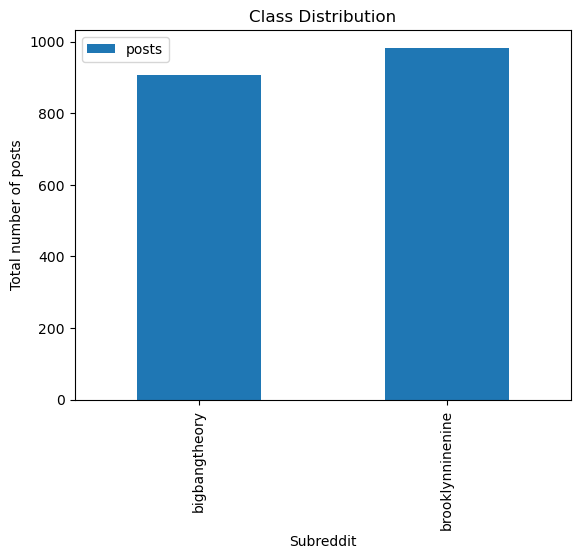

In [131]:
sitcom_df_count = sitcom_df.groupby('subreddit_').count()
display(sitcom_df_count)
print( 'Ratio:',
    sitcom_df_count['posts'][0]/sitcom_df_count['posts'].sum()
    , sitcom_df_count['posts'][1]/sitcom_df_count['posts'].sum()
)

# Plot subreddit distribution
plt.figure()
sitcom_df.groupby('subreddit_').count().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel("Subreddit")
plt.ylabel("Total number of posts")
plt.show()

## Feature Engineering

The `subreddit_` column, which is our target is not in numeric form. So we shall do a label encoder and convert the strings datatype into integer.
<br>`0`: Big Bang Theory
<br>`1`: Brooklyn Nine Nine

In [132]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Sieve out the columns which we want to apply label encoding on
sitcom_df['subreddit_'] = label_encoder.fit_transform(sitcom_df['subreddit_'])
sitcom_df

posts  subreddit_
0     Official Discord Server for r/bigbangtheory! H...           0
1     New 'Big Bang Theory' Spinoff in Development a...           0
2     Why did Jim Parsons want to move on from the s...           0
3                               Sing Soft Wookie To Me            0
4     Anyone here relate to a certain character and ...           0
...                                                 ...         ...
1884                            cheat day diet options            1
1885  Wife got me this shirt out of the blue, though...           1
1886                Some say that makes Zeus my Dad...            1
1887  If you had to guess, which lines would you say...           1
1888                      New “Jake Approves” template            1

[1889 rows x 2 columns]

## Exploratory Data Analysis

(for our eyes only. to remove later)
Interesting things in the posts: 
- !
- Capital letters / all uppercase
- emojis (how to detect emojis?)

In [133]:
# Define the stopwords & call Stemmer & Lemmatizer# customizing stopwords
extra_stopwords = ['subreddit', 'subreddits', 
#                    'show', 'like', 'episode',
#                    'would', 'character','one', 'think', 'season', 'time',
#                    'get', 'favourite', 'say', 'really', 'im', 'first',
#                     # Round 2
#                    'know', 'favorite', 'see', 'make', 'anyone', 'also',
#                    'love', 'got',
#                     # Round 3
#                    'series', 'much', 'could', 'dont', 'way',
#                     #Round 4
#                    'thing', 'watching', 'go',
#                     #Round 5
#                    'watch', 'thought',
#                     # Round 6
#                    'guy', 'always',
#                     # Round 7
#                    'character', 'else', 'even',
#                     # Round 8
#                    'want',
#                     # Round 9
#                    'something', 'feel',
#                     # Round 10
#                    'year',
#                     # Round 11
#                    'good',
#                     # Round 12
#                    'still',
#                     # Round 13
#                    'best', 'made',
#                     # Not a text
#                    'ampx200b'
]

In [134]:
stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

In [135]:
# Punctuations that will be removed from the post
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [136]:
# Get EDA plots by passing in the vectorizer

def get_plots(vectorizer, df):        
    
    # X_counts stores the vectorized version of the data
    X_counts = vectorizer.fit_transform(df['posts'])
    print('Shape of vectorised dataset:', X_counts.shape)
    
    # Returns the unique words in the text.
    print('\nChecking feature names:', vectorizer.get_feature_names_out())
    
    
    # Convert the vectorized output into a dataframe
    X_count_df = pd.DataFrame(X_counts.todense(), 
                              columns=vectorizer.get_feature_names_out())

    # Adding in y-labels for visualisation     
    sitcom_count_df = pd.concat([X_count_df,df['subreddit_']], axis=1)
    try:
        sitcom_count_df.drop(columns=[''], inplace=True)
    except:
        print('\nNo \'\' to remove.')
    print('\nConverting vectorized dataset into dataframe, and adding labels:')
    display(sitcom_count_df)

# Split data into 2 for EDA ------------------------------------------------------------------    

    bbt_cv_df = sitcom_count_df[sitcom_count_df['subreddit_']==0].drop('subreddit_', axis=1)
    bbt_top30 = bbt_cv_df.sum().sort_values(ascending=False).reset_index().head(30)
    bbt_top30.columns = ['words', 'count']
    
    b99_cv_df = sitcom_count_df[sitcom_count_df['subreddit_']==1].drop('subreddit_', axis=1)
    b99_top30 = b99_cv_df.sum().sort_values(ascending=False).reset_index().head(30)
    b99_top30.columns = ['words', 'count']

    # Create HTML table representations of the DataFrames with captions
    table1 = bbt_top30.style.set_caption('bbt_top30').to_html()
    table2 = b99_top30.style.set_caption('b99_top30').to_html()

    # Concatenate the HTML tables side by side
    html = '<table><tr><td>{}</td><td>{}</td></tr></table>'.format(table1, table2)

    print('\nComparing between the 2 datasets:')
    # Display the HTML table
    display(HTML(html))
    
    
# PLotting side-by-side plots for each subreddit ---------------------------
    
    fig, (ax_bbt, ax_b99) = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

    # Plotting for Big Bang Theory
    sns.barplot(data=bbt_top30, y='words', x='count', ax=ax_bbt)

    # Plotting for Brooklyn 99
    sns.barplot(data=b99_top30, y='words', x='count', ax=ax_b99)

    ax_bbt.set(title='Top 30 Used words for Big Bang Theory')
    ax_b99.set(title='Top 30 Used words for Brooklyn Nine Nine')

    plt.tight_layout()
    plt.show
    
# PLotting stacked bar chart ------------------------------------------------
    
    # Adding new row ('Total') to plot the stacked bar chart

    # Group by 'subreddit_y' and sum the values for each column
    grouped_df = sitcom_count_df.groupby('subreddit_').sum()

    # Calculate the sum of each column and create a DataFrame for total row
    total_row = pd.DataFrame(grouped_df.sum()).T
    total_row.index = ['Total']
    total_row.rename_axis('subreddit_',inplace=True)

    # # Concatenate the total row to the grouped DataFrame
    grouped_df = pd.concat([grouped_df, total_row])

    ## Sort by total sum:

    # Select the desired indexes for plotting (bigbangtheory, brooklynninenine, and Total)
    indexes = [0, 1, 'Total']

    # Select the rows to plot 
    columns_to_plot = grouped_df.loc[indexes].T.sort_values(by='Total', ascending=False).head(30)

    columns_to_plot.drop('Total', axis=1, inplace=True)

    # Plot the stacked bar chart
    ax = columns_to_plot.plot(kind='barh', stacked=True)

    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.title('Top 30 common words from both subreddits combined (Tag: Hot)')

    # Modify the legend name
    legend_labels = ['bigbangtheory', 'brooklynninenine']
    ax.legend(legend_labels)
    
    plt.show()
    
    display(columns_to_plot.head(10))
#     create_plots(bbt_top30,b99_top30)

In [137]:
# Define a function that removes puntuation, tokenise the string & remove stopwords

def clean_text(text):
    # Punctuation removal.
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    
    # Tokenisation.
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # Apply lemmatisation and stopwords exclusion within the same step.
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
#     text = " ".join(text)
    return text

### CountVectorizer (Single word)

Vectorized the words using Count Vectorization

Shape of vectorised dataset: (1889, 7628)

Checking feature names: ['' '0' '0400ish' ... 'zoom' 'zoomins' '½']

Converting vectorized dataset into dataframe, and adding labels:


0  0400ish  05  07x04  07x05  08  1  10  100  10th  ...  zeep  zero  \
0     0        0   0      0      0   0  0   0    0     0  ...     0     0   
1     0        0   0      0      0   0  0   0    0     0  ...     0     0   
2     0        0   0      0      0   0  0   0    0     0  ...     0     0   
3     0        0   0      0      0   0  0   0    0     0  ...     0     0   
4     0        0   0      0      0   0  0   0    0     0  ...     0     0   
...  ..      ...  ..    ...    ...  .. ..  ..  ...   ...  ...   ...   ...   
1884  0        0   0      0      0   0  0   0    0     0  ...     0     0   
1885  0        0   0      0      0   0  0   0    0     0  ...     0     0   
1886  0        0   0      0      0   0  0   0    0     0  ...     0     0   
1887  0        0   0      0      0   0  0   0    0     0  ...     0     0   
1888  0        0   0      0      0   0  0   0    0     0  ...     0     0   

      zeus  zimble  zinger  zoo  zoom  zoomins  ½  subreddit_  
0        0       0       0    0     0        0  0           0  
1        0       0       0    0     0        0  0           0  
2        0       0       0    0     0        0  0           0  
3        0       0       0    0     0        0  0           0  
4        0       0       0    0     0        0  0           0  
...    ...     ...     ...  ...   ...      ... ..         ...  
1884     0       0       0    0     0        0  0           1  
1885     0       0       0    0     0        0  0           1  
1886     1       0       0    0     0        0  0           1  
1887     0       0       0    0     0        0  0           1  
1888     0       0       0    0     0        0  0           1  

[1889 rows x 7628 columns]


Comparing between the 2 datasets:


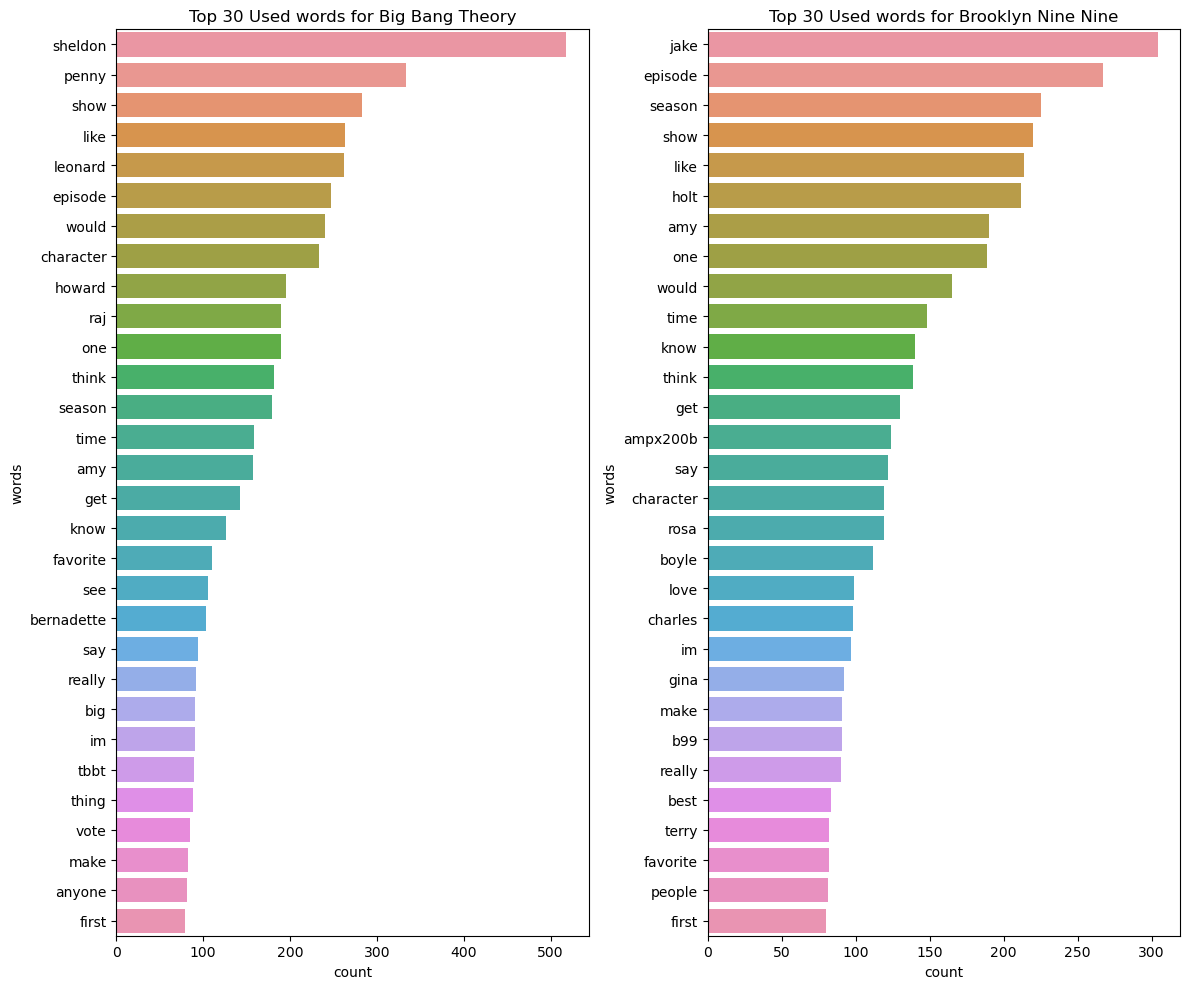

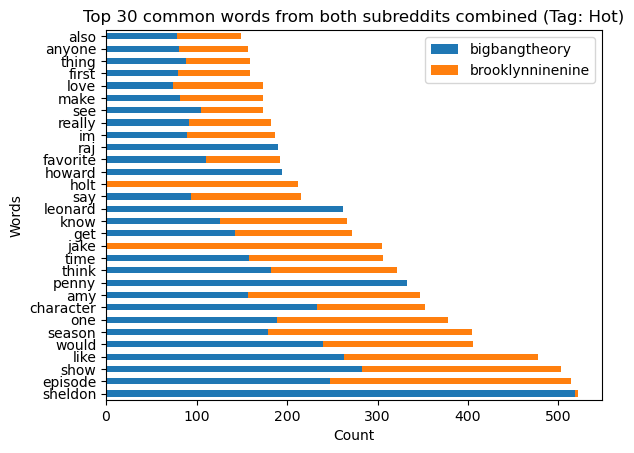

subreddit_    0    1
sheldon     518    4
episode     247  267
show        283  220
like        263  214
would       240  165
season      179  225
one         189  189
character   233  119
amy         157  190
penny       333    0

In [138]:
# Create an instance of CountVectorizer and pass in the clean_text function as the analyzer parameter
count_vect = CountVectorizer(analyzer=clean_text)
get_plots(count_vect, sitcom_df)

### TfidfVectorizer

Shape of vectorised dataset: (1889, 7628)

Checking feature names: ['' '0' '0400ish' ... 'zoom' 'zoomins' '½']

Converting vectorized dataset into dataframe, and adding labels:


0  0400ish   05  07x04  07x05   08    1   10  100  10th  ...  zeep  \
0     0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
1     0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
2     0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
3     0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
4     0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
...   ...      ...  ...    ...    ...  ...  ...  ...  ...   ...  ...   ...   
1884  0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
1885  0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
1886  0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
1887  0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   
1888  0.0      0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0   0.0  ...   0.0   

      zero      zeus  zimble  zinger  zoo  zoom  zoomins    ½  subreddit_  
0      0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           0  
1      0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           0  
2      0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           0  
3      0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           0  
4      0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           0  
...    ...       ...     ...     ...  ...   ...      ...  ...         ...  
1884   0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           1  
1885   0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           1  
1886   0.0  0.731112     0.0     0.0  0.0   0.0      0.0  0.0           1  
1887   0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           1  
1888   0.0  0.000000     0.0     0.0  0.0   0.0      0.0  0.0           1  

[1889 rows x 7628 columns]


Comparing between the 2 datasets:


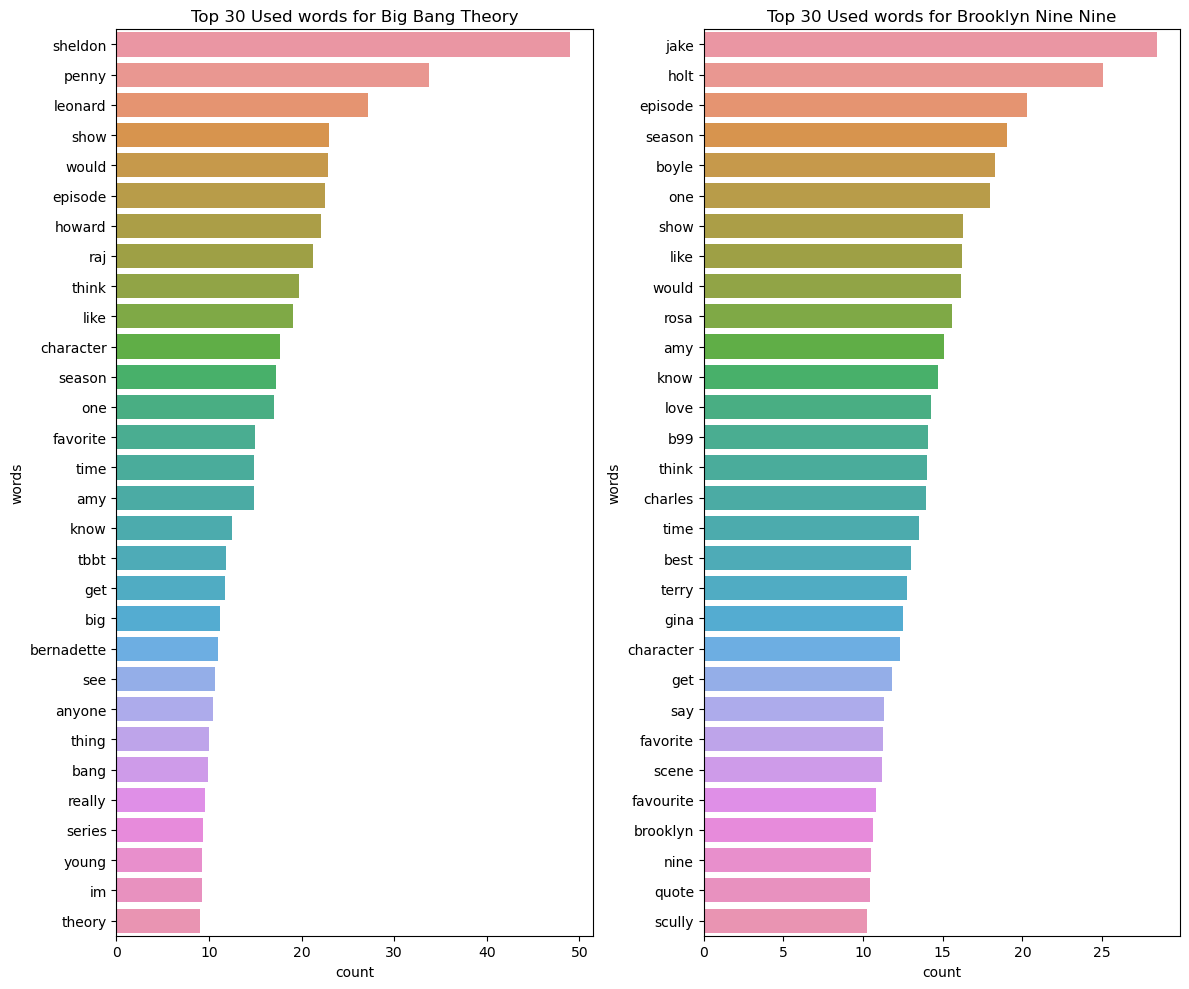

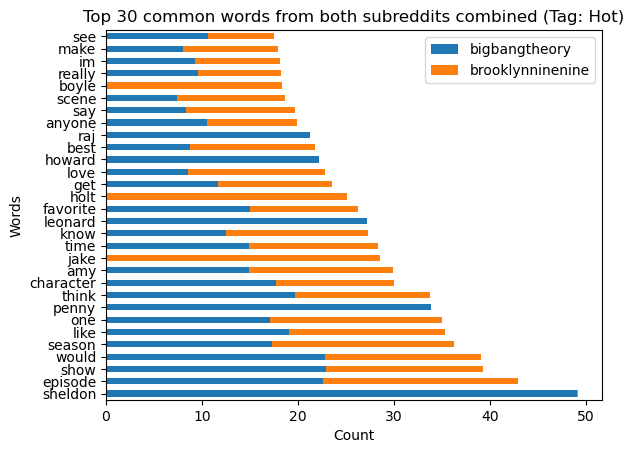

subreddit_          0          1
sheldon     48.990250   0.196288
episode     22.568994  20.313140
show        22.939581  16.260769
would       22.849649  16.163302
season      17.260275  19.019420
like        19.094103  16.179861
one         17.037706  17.980968
penny       33.801699   0.000000
think       19.725994  13.984133
character   17.716980  12.302021

In [139]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
get_plots(tfidf_vect, sitcom_df)

### CountVectorizer (Bigrams)

Since Bigrams using 2 words, those extra words that was removed may have an impact on it. Hence lets use the default stopswords and create another function for the text cleaning as Bigram requires the whole string to be pass in.

In [140]:
extra_stopwards_bi = ['ampx200b']
stopwords_bi = nltk.corpus.stopwords.words('english') + extra_stopwards_bi

In [141]:
# Define a function that removes puntuation, tokenise the string & remove stopwords
def clean_text_bi(text):
    # Punctuation removal.
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    
    # Apply lemmatisation and stopwords exclusion within the same step.
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopwords_bi])
    return text

In [142]:
#Preprocess and prepare a copy of data to pass into get_plots()
sitcom_df['cleaned_text'] = sitcom_df['posts'].apply(lambda x: clean_text_bi(x))
sitcom_df.head()

# Renaming 'cleaned_text' to 'posts' so as to pass it into the 'get_plots' function
sitcom_df_2 = sitcom_df.copy()
sitcom_df_2.drop('posts', axis=1, inplace=True)
sitcom_df_2.rename(columns={'cleaned_text': 'posts'}, inplace=True)
sitcom_df_2

subreddit_                                              posts
0              0  official discord server rbigbangtheory hi made...
1              0  new big bang theory spinoff development hbo ma...
2              0  jim parson want move show character continues ...
3              0                                  sing soft wookie 
4              0  anyone relate certain character raj socially i...
...          ...                                                ...
1884           1                             cheat day diet option 
1885           1       wife got shirt blue thought folk would like 
1886           1                                 say make zeus dad 
1887           1  guess line would say improvised partially impr...
1888           1                        new jake approves template 

[1889 rows x 2 columns]

Shape of vectorised dataset: (1889, 35364)

Checking feature names: ['05 pissed' '07x04 discus' '07x05 sheldon' ... 'zoom rosa' 'zoom use'
 'zoomins tie']

No '' to remove.

Converting vectorized dataset into dataframe, and adding labels:


05 pissed  07x04 discus  07x05 sheldon  08 s4  10 11  10 day  \
0             0             0              0      0      0       0   
1             0             0              0      0      0       0   
2             0             0              0      0      0       0   
3             0             0              0      0      0       0   
4             0             0              0      0      0       0   
...         ...           ...            ...    ...    ...     ...   
1884          0             0              0      0      0       0   
1885          0             0              0      0      0       0   
1886          0             0              0      0      0       0   
1887          0             0              0      0      0       0   
1888          0             0              0      0      0       0   

      10 episode  10 etc  10 feeling  10 game  ...  zero sense  zeus dad  \
0              0       0           0        0  ...           0         0   
1              0       0           0        0  ...           0         0   
2              0       0           0        0  ...           0         0   
3              0       0           0        0  ...           0         0   
4              0       0           0        0  ...           0         0   
...          ...     ...         ...      ...  ...         ...       ...   
1884           0       0           0        0  ...           0         0   
1885           0       0           0        0  ...           0         0   
1886           0       0           0        0  ...           0         1   
1887           0       0           0        0  ...           0         0   
1888           0       0           0        0  ...           0         0   

      zimble interested  zinger like  zinger two  zoo make  zoom rosa  \
0                     0            0           0         0          0   
1                     0            0           0         0          0   
2                     0            0           0         0          0   
3                     0            0           0         0          0   
4                     0            0           0         0          0   
...                 ...          ...         ...       ...        ...   
1884                  0            0           0         0          0   
1885                  0            0           0         0          0   
1886                  0            0           0         0          0   
1887                  0            0           0         0          0   
1888                  0            0           0         0          0   

      zoom use  zoomins tie  subreddit_  
0            0            0           0  
1            0            0           0  
2            0            0           0  
3            0            0           0  
4            0            0           0  
...        ...          ...         ...  
1884         0            0           1  
1885         0            0           1  
1886         0            0           1  
1887         0            0           1  
1888         0            0           1  

[1889 rows x 35365 columns]


Comparing between the 2 datasets:


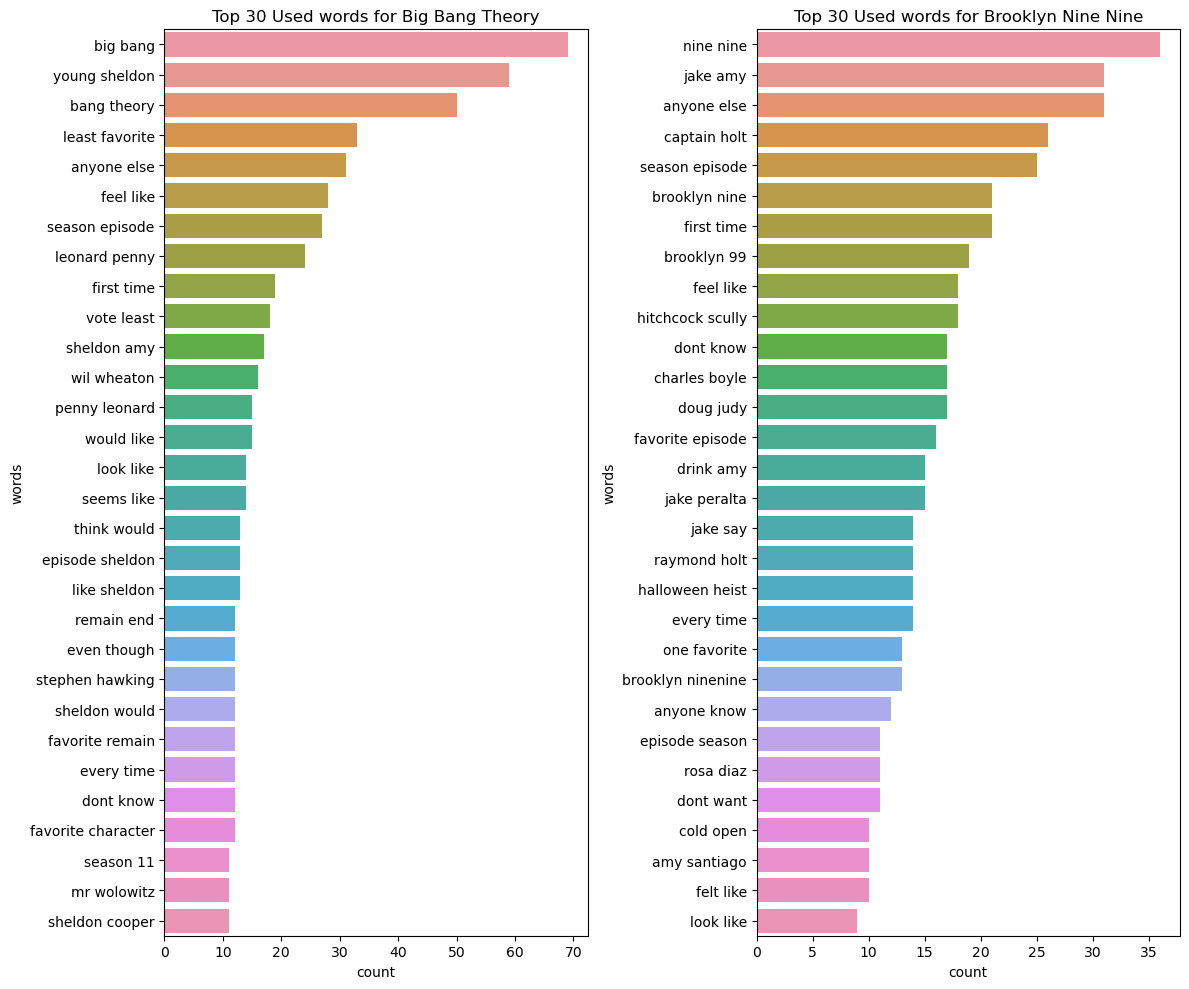

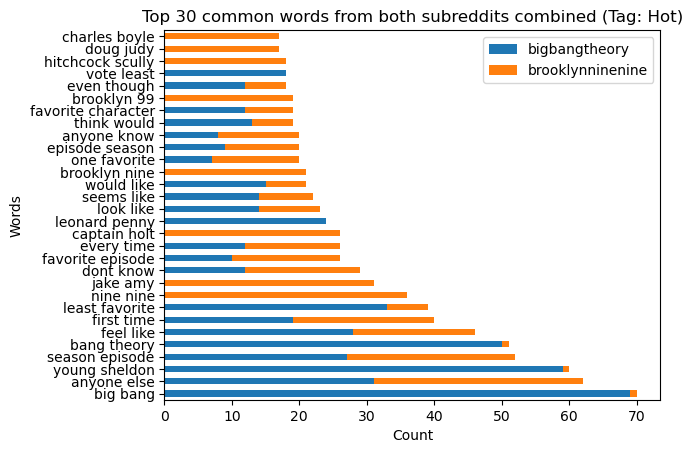

subreddit_       0   1
big bang        69   1
anyone else     31  31
young sheldon   59   1
season episode  27  25
bang theory     50   1
feel like       28  18
first time      19  21
least favorite  33   6
nine nine        0  36
jake amy         0  31

In [143]:
# Create an instance of CountVectorizer for Bigrams
ngram_vect = CountVectorizer(ngram_range=(2,2))
get_plots(ngram_vect, sitcom_df_2)

### CountVectorizer (Trigrams)

In [144]:
extra_stopwards_tri =['episode', 'like', 'show', 'ampx200b', 'character']
stopwords_tri = nltk.corpus.stopwords.words('english') + extra_stopwards_tri

In [145]:
# Define a function that removes puntuation, tokenise the string & remove stopwords
def clean_text_tri(text):
    # Punctuation removal.
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    
    # Apply lemmatisation and stopwords exclusion within the same step.
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopwords_tri])
    return text

In [146]:
sitcom_df['cleaned_text_v2'] = sitcom_df['posts'].apply(lambda x: clean_text_tri(x))

# Renaming 'cleaned_text_v2' to 'posts' so as to pass it into the 'get_plots' function
sitcom_df_3 = sitcom_df.copy()
sitcom_df_3.drop('posts', axis=1, inplace=True)
sitcom_df_3.rename(columns={'cleaned_text_v2': 'posts'}, inplace=True)
sitcom_df_3

subreddit_                                       cleaned_text  \
0              0  official discord server rbigbangtheory hi made...   
1              0  new big bang theory spinoff development hbo ma...   
2              0  jim parson want move show character continues ...   
3              0                                  sing soft wookie    
4              0  anyone relate certain character raj socially i...   
...          ...                                                ...   
1884           1                             cheat day diet option    
1885           1       wife got shirt blue thought folk would like    
1886           1                                 say make zeus dad    
1887           1  guess line would say improvised partially impr...   
1888           1                        new jake approves template    

                                                  posts  
0     official discord server rbigbangtheory hi made...  
1     new big bang theory spinoff development hbo ma...  
2     jim parson want move continues produce narrate...  
3                                     sing soft wookie   
4     anyone relate certain raj socially inept espec...  
...                                                 ...  
1884                             cheat day diet option   
1885            wife got shirt blue thought folk would   
1886                                 say make zeus dad   
1887  guess line would say improvised partially impr...  
1888                        new jake approves template   

[1889 rows x 3 columns]

Shape of vectorised dataset: (1889, 5000)

Checking feature names: ['05 pissed amy' '11 season 12' '1214 participate reddit' ...
 'young sheldon meemaw' 'young sheldon see' 'young sheldon watch']

No '' to remove.

Converting vectorized dataset into dataframe, and adding labels:


05 pissed amy  11 season 12  1214 participate reddit  24 dr gablehauser  \
0                 0             0                        0                  0   
1                 0             0                        0                  0   
2                 0             0                        0                  0   
3                 0             0                        0                  0   
4                 0             0                        0                  0   
...             ...           ...                      ...                ...   
1884              0             0                        0                  0   
1885              0             0                        0                  0   
1886              0             0                        0                  0   
1887              0             0                        0                  0   
1888              0             0                        0                  0   

      25 leslie winkle  26 colonel williams  27 beverly 28  28 anu 29  \
0                    0                    0              0          0   
1                    0                    0              0          0   
2                    0                    0              0          0   
3                    0                    0              0          0   
4                    0                    0              0          0   
...                ...                  ...            ...        ...   
1884                 0                    0              0          0   
1885                 0                    0              0          0   
1886                 0                    0              0          0   
1887                 0                    0              0          0   
1888                 0                    0              0          0   

      29 priya 30  2nd place day  ...  wrong 23 time  yellow crested warbler  \
0               0              0  ...              0                       0   
1               0              0  ...              0                       0   
2               0              0  ...              0                       0   
3               0              0  ...              0                       0   
4               0              0  ...              0                       0   
...           ...            ...  ...            ...                     ...   
1884            0              0  ...              0                       0   
1885            0              0  ...              0                       0   
1886            0              0  ...              0                       0   
1887            0              0  ...              0                       0   
1888            0              0  ...              0                       0   

      yesterday 2nd place  yesterday comment consistent  youd think would  \
0                       0                             0                 0   
1                       0                             0                 0   
2                       0                             0                 0   
3                       0                             0                 0   
4                       0                             0                 0   
...                   ...                           ...               ...   
1884                    0                             0                 0   
1885                    0                             0                 0   
1886                    0                             0                 0   
1887                    0                             0                 0   
1888                    0                             0                 0   

      young sheldon amp  young sheldon meemaw  young sheldon see  \
0                     0                     0                  0   
1                     0                     0                  0   
2                     0                     0                  0  


Comparing between the 2 datasets:


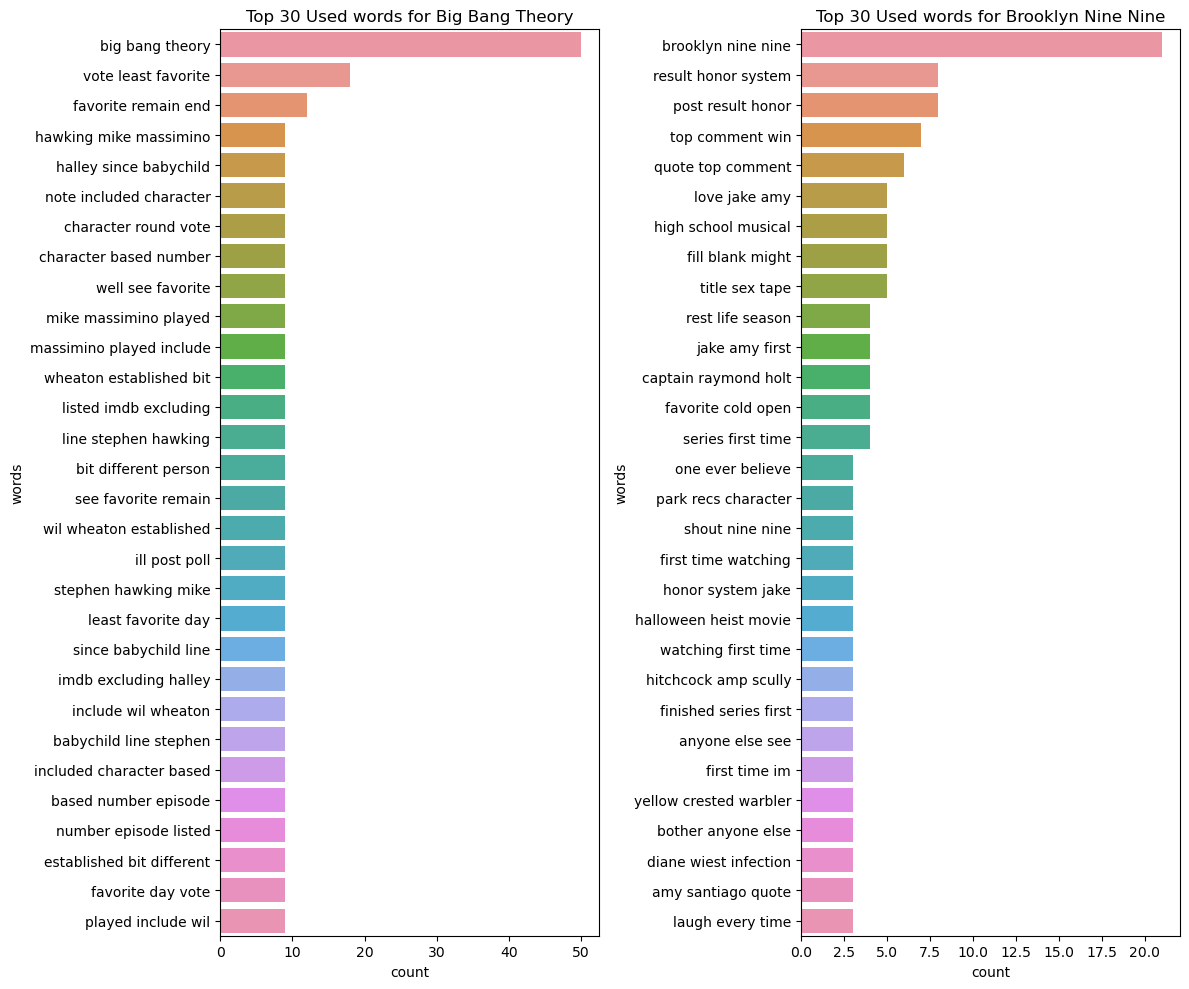

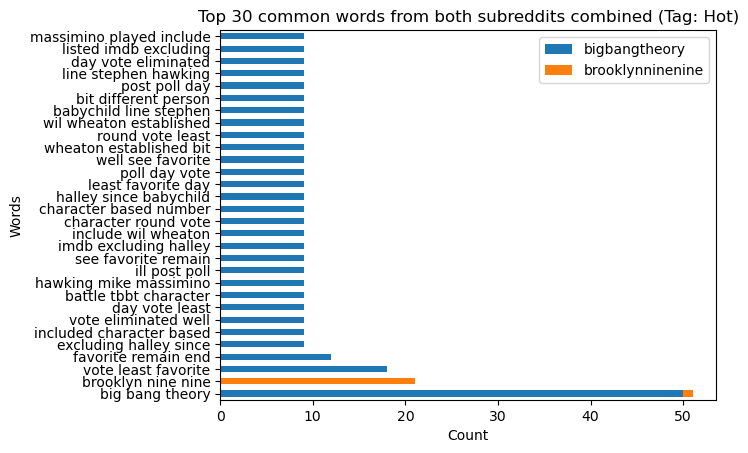

subreddit_                 0   1
big bang theory           50   1
brooklyn nine nine         0  21
vote least favorite       18   0
favorite remain end       12   0
excluding halley since     9   0
included character based   9   0
vote eliminated well       9   0
day vote least             9   0
battle tbbt character      9   0
hawking mike massimino     9   0

In [147]:
ngram_vect_tri = CountVectorizer(ngram_range=(3,3), max_features = 5000)
# X_counts3_b99 = ngram_vect_b99_tri.fit_transform(b99['cleaned_text'])

# ngram_vect = CountVectorizer(ngram_range=(2,2))
get_plots(ngram_vect_tri, sitcom_df_3)

### Exploring other elements using `sitcom_df_x`

#### Length of post

In [148]:
sitcom_df_x = sitcom_df.copy()
sitcom_df_x['len_posts'] =  sitcom_df_x['posts'].apply(lambda x: len(x))
sitcom_df_x.head()

posts  subreddit_  \
0  Official Discord Server for r/bigbangtheory! H...           0   
1  New 'Big Bang Theory' Spinoff in Development a...           0   
2  Why did Jim Parsons want to move on from the s...           0   
3                            Sing Soft Wookie To Me            0   
4  Anyone here relate to a certain character and ...           0   

                                        cleaned_text  \
0  official discord server rbigbangtheory hi made...   
1  new big bang theory spinoff development hbo ma...   
2  jim parson want move show character continues ...   
3                                  sing soft wookie    
4  anyone relate certain character raj socially i...   

                                     cleaned_text_v2  len_posts  
0  official discord server rbigbangtheory hi made...        385  
1  new big bang theory spinoff development hbo ma...         73  
2  jim parson want move continues produce narrate...        113  
3                                  sing soft wookie          23  
4  anyone relate certain raj socially inept espec...        138

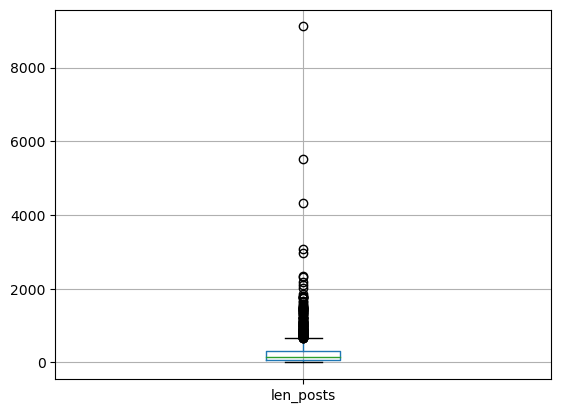

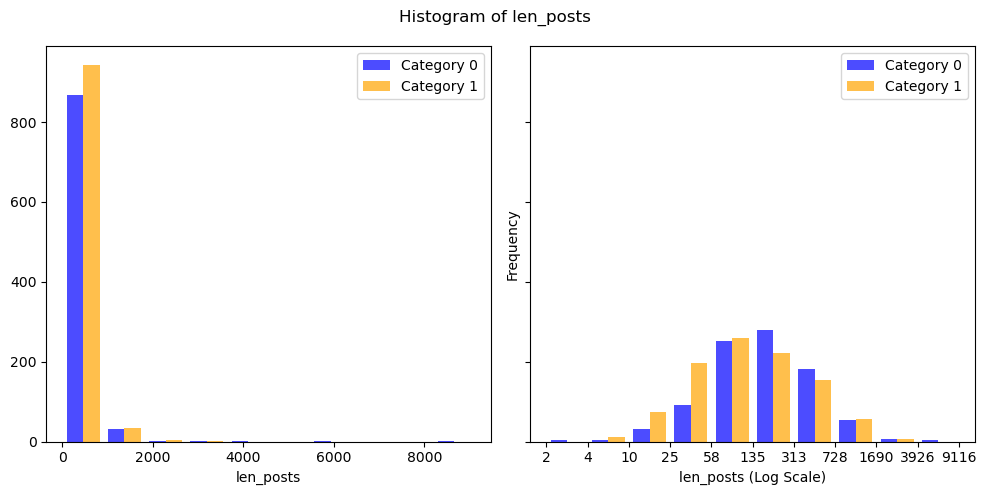

In [149]:
## Show boxplot
sitcom_df_x[['len_posts']].boxplot()

# Apply logarithm to the 'len_posts' column
log_len_posts = np.log(sitcom_df_x['len_posts'])

# Create a figure and two subplots (axes)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot histogram for each category separately
subreddit_0 = sitcom_df_x.loc[sitcom_df_x['subreddit_'] == 0, 'len_posts']
subreddit_1 = sitcom_df_x.loc[sitcom_df_x['subreddit_'] == 1, 'len_posts']

ax1.hist([subreddit_0, subreddit_1], color=['blue', 'orange'], label=['Category 0', 'Category 1'], alpha=0.7)
ax1.set_xlabel('len_posts')
ax1.legend()

# Plot the histogram with log scaled x-axis on the right side
n, bins, patches = ax2.hist([log_len_posts.loc[sitcom_df_x['subreddit_'] == 0], log_len_posts.loc[sitcom_df_x['subreddit_'] == 1]],
                           color=['blue', 'orange'], label=['Category 0', 'Category 1'], alpha=0.7)
ax2.set_xlabel('len_posts (Log Scale)')
ax2.set_ylabel('Frequency')

ax2.set_xticks(ticks=bins)
ax2.set_xticklabels(labels=np.exp(bins).astype(int))
ax2.legend()

fig.suptitle('Histogram of len_posts')

fig.tight_layout()
plt.show()


#### Number of Emojis

In [150]:
# Function to detect emojis in a given text
def detect_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(text)
    return emojis

sitcom_df_x['emojis'] = sitcom_df_x['posts'].apply(detect_emojis)

sitcom_df_x.head()

posts  subreddit_  \
0  Official Discord Server for r/bigbangtheory! H...           0   
1  New 'Big Bang Theory' Spinoff in Development a...           0   
2  Why did Jim Parsons want to move on from the s...           0   
3                            Sing Soft Wookie To Me            0   
4  Anyone here relate to a certain character and ...           0   

                                        cleaned_text  \
0  official discord server rbigbangtheory hi made...   
1  new big bang theory spinoff development hbo ma...   
2  jim parson want move show character continues ...   
3                                  sing soft wookie    
4  anyone relate certain character raj socially i...   

                                     cleaned_text_v2  len_posts emojis  
0  official discord server rbigbangtheory hi made...        385     []  
1  new big bang theory spinoff development hbo ma...         73     []  
2  jim parson want move continues produce narrate...        113     []  
3                                  sing soft wookie          23     []  
4  anyone relate certain raj socially inept espec...        138     []

Checking rows with emojis present:

In [151]:
# Create the new column 'num_emojis' containing the number of emojis
sitcom_df_x['num_emojis'] = sitcom_df_x['emojis'].apply(lambda x: len(x))

In [152]:
# Filter the dataframe to show rows with non-empty lists in the 'emojis' column
sitcom_df_x[sitcom_df_x['emojis'].apply(lambda x: len(x) > 0)]

posts  subreddit_  \
10    The “Dumb Hot Guy” character, for this ex Zack...           0   
26    I ate a butterfly! 😳 This is my favorite Howar...           0   
34    has anyone else cried bc of the show or am I j...           0   
53                                                   🙌            0   
111   I had a weird BBT dream but it was wholesome a...           0   
...                                                 ...         ...   
1779  b99 flashback detail i love rewatching for the...           1   
1790                         Top tier spirit animal 🤌🏻            1   
1851  Why didnt holt use the wuntch blackmail?? \nIn...           1   
1858  Rosa couldn't help but smile after Charles ins...           1   
1865  Currently rewatching and I love Charles I’m wa...           1   

                                           cleaned_text  \
10    dumb hot guy character ex zack question applie...   
26    ate butterfly favorite howard quote crack ever...   
34    anyone else cried bc show absolute dork plz sh...   
53                                                        
111   weird bbt dream wholesome left wishing true id...   
...                                                 ...   
1779  b99 flashback detail love rewatching million 1...   
1790                            top tier spirit animal    
1851  didnt holt use wuntch blackmail season 2 wuntc...   
1858  rosa couldnt help smile charles insult terry kid    
1865  currently rewatching love charles watching eve...   

                                        cleaned_text_v2  len_posts  \
10    dumb hot guy ex zack question applies many com...        704   
26    ate butterfly favorite howard quote crack ever...         82   
34    anyone else cried bc absolute dork plz share m...        360   
53                                                               2   
111   weird bbt dream wholesome left wishing true id...       1311   
...                                                 ...        ...   
1779  b99 flashback detail love rewatching million 1...        285   
1790                            top tier spirit animal          26   
1851  didnt holt use wuntch blackmail season 2 wuntc...       1057   
1858  rosa couldnt help smile charles insult terry kid          66   
1865  currently rewatching love charles watching eve...        131   

            emojis  num_emojis  
10            [💨💨]           1  
26             [😳]           1  
34             [😭]           1  
53             [🙌]           1  
111   [😂, 😅, 😊, 😂]           4  
...            ...         ...  
1779           [🏾]           1  
1790           [🏻]           1  
1851           [😭]           1  
1858           [😂]           1  
1865           [💜]           1  

[91 rows x 7 columns]

In [153]:
print(sitcom_df_x['posts'][10])
print(sitcom_df_x['posts'][111])

The “Dumb Hot Guy” character, for this ex Zack So while my question applies to many comedies, I’m using BBT as the example. 
I understand it’s a common comedic tool to have the “dumb hot guy”… however I can’t really think of a time/show where it has been done in a believable fashion. 
Sure, I’ve met some… less then intelligent people. But more often I would compare them to a Penny type character. 
IMO a lot of the things Zach says are immensely lacking anything tangible to me. Yes, I understand it’s for comedic effect and therefore exaggerated. I guess it’s just too far for me??? (Or Joey in Friends, getting dumber each season for ex. Also) 
I hope I’m explaining my reasoning in this 💨💨 tangent.
I had a weird BBT dream but it was wholesome and it left me wishing it was true😂 idk who to share this with bcause nobody else in my circle of friends watches BBT. So I'm just sharing it here if anybody even reads it😅 So if you would also like to share your weird or funny dreams abt BBT please 

Inaccuracies in number of emojis identified:
- Emojis that are typed together are identified as 1 emoji.
- Separate repeated emojis are identified as 1 emoji.

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


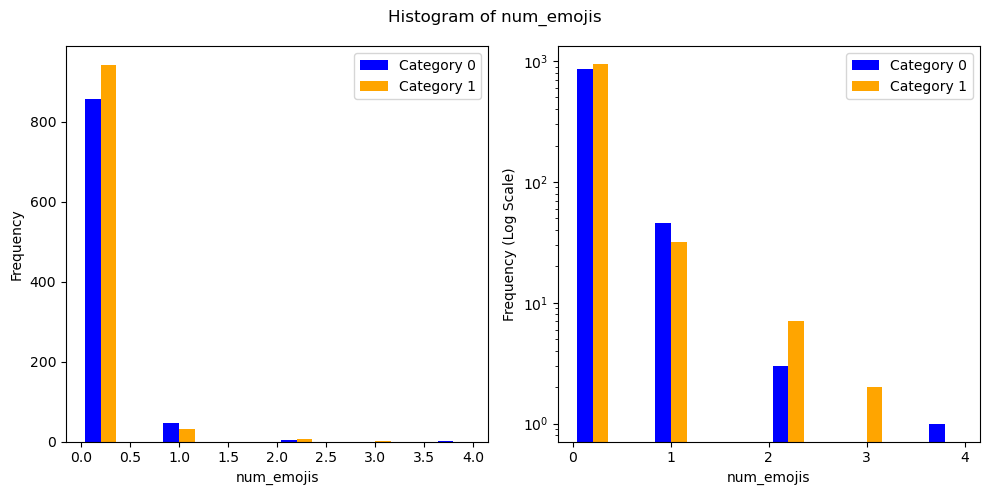

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# Extract data for each category
subreddit_0_data = sitcom_df_x.loc[sitcom_df_x['subreddit_'] == 0, 'num_emojis']
subreddit_1_data = sitcom_df_x.loc[sitcom_df_x['subreddit_'] == 1, 'num_emojis']

# Left plot
ax1.hist([subreddit_0_data, subreddit_1_data], color=['blue', 'orange'], label=['Category 0', 'Category 1'])
ax1.set_xlabel('num_emojis')
ax1.set_ylabel('Frequency')
ax1.legend()

# Right plot with a logged y-axis and integer x-axis
ax2.hist([subreddit_0_data, subreddit_1_data], color=['blue', 'orange'], label=['Category 0', 'Category 1'])
ax2.set_xlabel('num_emojis')
ax2.set_ylabel('Frequency (Log Scale)')
ax2.set_yscale('log')
ax2.set_xticks(range(5))  
ax2.set_xticklabels(range(5)) 
ax2.legend()

fig.suptitle('Histogram of num_emojis')

fig.tight_layout()
plt.show()

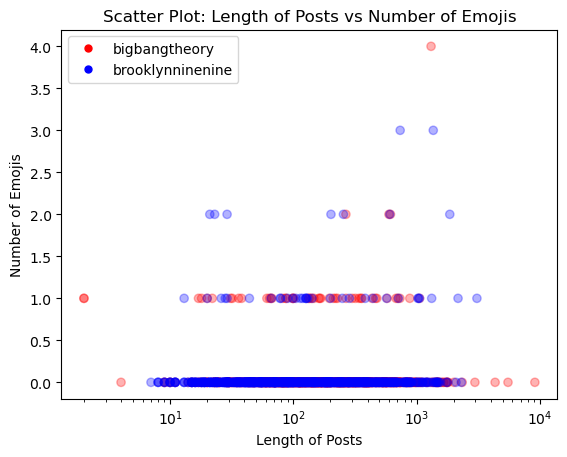

In [155]:
# Scatter plot with different colors for each 'subreddit_' category
plt.scatter(sitcom_df_x['len_posts'], sitcom_df_x['num_emojis'],
            c=sitcom_df_x['subreddit_'].map({0: 'red', 1: 'blue'}),
            alpha=0.3)

# Log scale the x-axis
plt.xscale('log')

plt.xlabel('Length of Posts')
plt.ylabel('Number of Emojis')
plt.title('Scatter Plot: Length of Posts vs Number of Emojis')

legend_labels = ['bigbangtheory', 'brooklynninenine']
legend_colors = ['red', 'blue']

# Create custom legend handles
handles = [plt.Line2D([], [], marker='o', markersize=5, color=color, linestyle='') for color in legend_colors]

plt.legend(handles, legend_labels)

plt.show()

In [156]:
sitcom_df_x.groupby('subreddit_')['num_emojis','len_posts'].mean()

C:\Users\jinji\AppData\Local\Temp\ipykernel_11360\2594455029.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sitcom_df_x.groupby('subreddit_')['num_emojis','len_posts'].mean()


num_emojis   len_posts
subreddit_                        
0             0.061810  288.428256
1             0.052899  228.972533

## Modeling

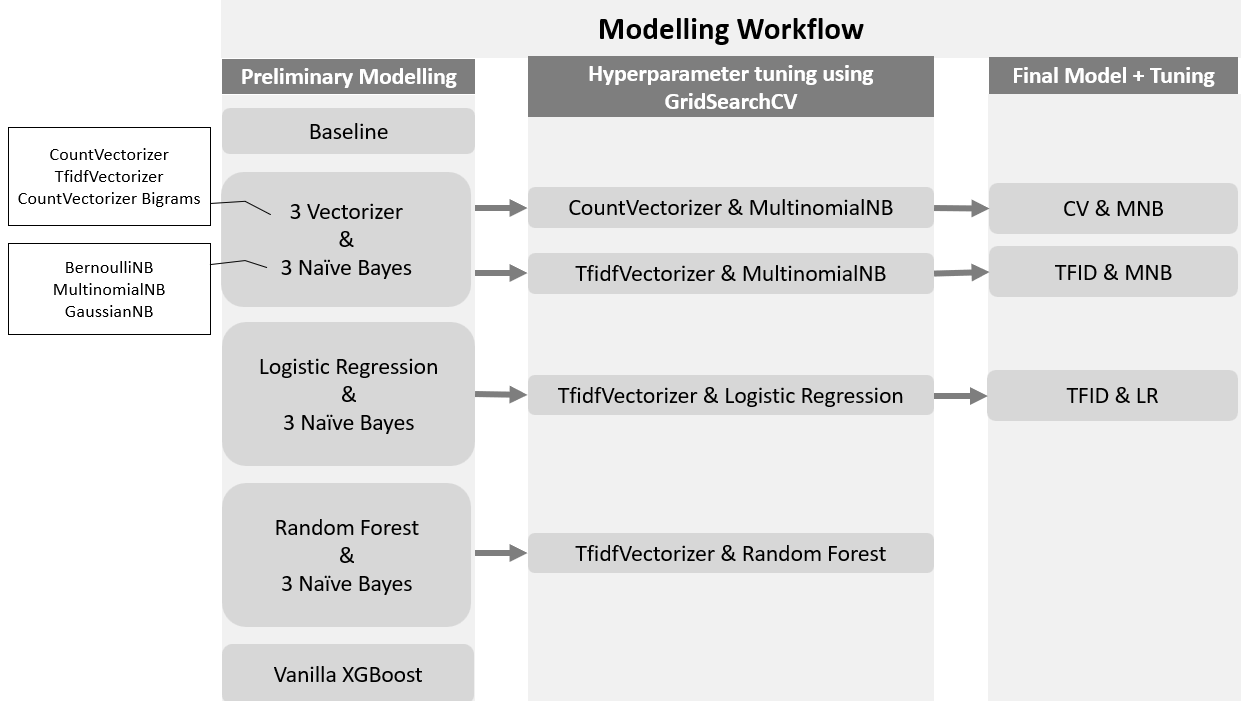

In [228]:
# Define a function that returns the model scores
# Set view_cm to True to get confusion matrix visualisation
def get_model_score (X, y, pipe, view_cm = False):
    
    # Split the data into train & test by 70 / 30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fit the data
    pipe.fit(X_train, y_train)
    display(pipe) # Remove is there is an error
    
    # Make prediction with the model 
    y_pred = pipe.predict(X_test)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn / (tn + fp)

    print(classification_report(y_test, y_pred))
    print(f'Accuracy (train): {pipe.score(X_train, y_train)}')
    print(f'Accuracy (test): {pipe.score(X_test, y_test)}')
    print(f'Cross-val-score(cv=5): {cross_val_score(pipe, X_train, y_train, cv=5).mean()}')
    print(f'Sensitivity(TPR): {recall_score(y_test, y_pred)}')
    print(f'Specificity(TNR): {spec}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print('-------------------------------------------------------\n')
    
    if view_cm: 
        
        cm = confusion_matrix(y_test, y_pred)

        ax = sns.heatmap(data=cm, cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True), annot=[[f"TN={cm[0][0]:.0f}", f"FN={cm[0][1]:.0f}"], [f"FP={cm[1][0]:.0f}", f"TP={cm[1][1]:.0f}"]],
                         fmt='', annot_kws={'fontsize': 24}, cbar=False, square=True)

        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.tick_params(length=0, labeltop=True, labelbottom=False)
        ax.xaxis.set_label_position('top')
        ax.set_xticklabels(['Negative (0)', 'Positive (1)'])
        ax.set_yticklabels(['Negative (0)', 'Positive (1)'], rotation=90, va='center')
        ax.add_patch(plt.Rectangle((0, 1), 1, 0.1, color='ivory', clip_on=False, zorder=0, transform=ax.transAxes))
        ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='ivory', clip_on=False, zorder=0, transform=ax.transAxes))
        plt.tight_layout()
        plt.show()
    
    return pipe

In [229]:
# Define a function that runs GridSearchCV with the Parameters given & return the scores
def get_gridsearch_params(X, y, model, params, folds):
    # Split the data into train & test by 70 / 30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate the GridSearchCV model
    gs_model = GridSearchCV(estimator=model,
                            param_grid=params,
                            scoring='accuracy',
                            cv=folds,
                            verbose=2
    )
    
    # Fit the model
    gs_model.fit(X_train, y_train)
    y_pred = gs_model.predict(X_test)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn / (tn + fp)
    
    print(f'Best Hyperparameters: {gs_model.best_params_}') # Display the best hyperparameters for the selected model
    print(f'Best training accuracy: {gs_model.best_score_}')
    print(f'Test set accuracy score for best params: {accuracy_score(y_test, y_pred)}')
    # Display the scores for the GridSearched Best Model
    print('-------------------------------------------------------\n')
    print(classification_report(y_test, y_pred))
    print(f'Sensitivity(TPR): {recall_score(y_test, y_pred)}')
    print(f'Specificity(TNR): {spec}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print('-------------------------------------------------------\n')
    return gs_model

### Baseline accuracy

We need to calculate baseline accuracy in order to tell if our model is better than null model (predicting the plurality class)

In [230]:
# Define the X & y
X = sitcom_df['posts']
y = sitcom_df['subreddit_']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)
y_test.value_counts(normalize=True)

1    0.520833
0    0.479167
Name: subreddit_, dtype: float64

### Naive Bayes

There are 3 types of Vecorization technique and 3 Naive Bayes model to test on. So lets run these thru piepline and fit our post data in.

Let's run CountVectorizer with all 3 Naive Bayes Model.

BernoulliNB with CountVectorizer


Pipeline(steps=[('cv',
                 CountVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>)),
                ('nb', BernoulliNB())])

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       265
           1       0.83      0.97      0.90       302

    accuracy                           0.88       567
   macro avg       0.90      0.88      0.88       567
weighted avg       0.89      0.88      0.88       567

Accuracy (train): 0.9039334341906202
Accuracy (test): 0.8818342151675485
Cross-val-score(cv=5): 0.8373842195540309
Sensitivity(TPR): 0.9735099337748344
Specificity(TNR): 0.7773584905660378
Precision: 0.8328611898016998
-------------------------------------------------------



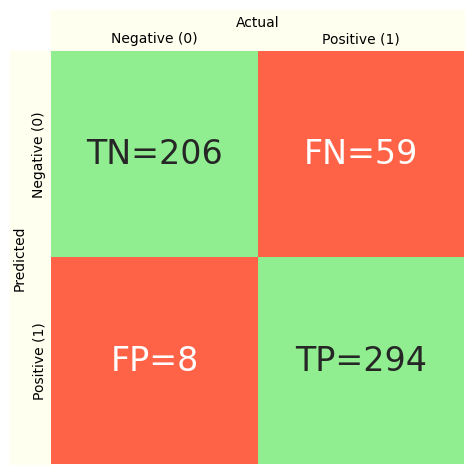

MultinomialNB with CountVectorizer


Pipeline(steps=[('cv',
                 CountVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>)),
                ('nb', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       265
           1       0.91      0.91      0.91       302

    accuracy                           0.91       567
   macro avg       0.91      0.91      0.91       567
weighted avg       0.91      0.91      0.91       567

Accuracy (train): 0.9644478063540091
Accuracy (test): 0.9065255731922398
Cross-val-score(cv=5): 0.8774499714122357
Sensitivity(TPR): 0.9105960264900662
Specificity(TNR): 0.9018867924528302
Precision: 0.9136212624584718
-------------------------------------------------------

GaussianNB with CountVectorizer


Pipeline(steps=[('cv',
                 CountVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>)),
                ('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x000001C3518576D0>)),
                ('gnb', GaussianNB())])

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       265
           1       0.83      0.93      0.88       302

    accuracy                           0.86       567
   macro avg       0.87      0.86      0.86       567
weighted avg       0.87      0.86      0.86       567

Accuracy (train): 0.9636913767019667
Accuracy (test): 0.8624338624338624
Cross-val-score(cv=5): 0.8244797026872499
Sensitivity(TPR): 0.9271523178807947
Specificity(TNR): 0.7886792452830189
Precision: 0.8333333333333334
-------------------------------------------------------



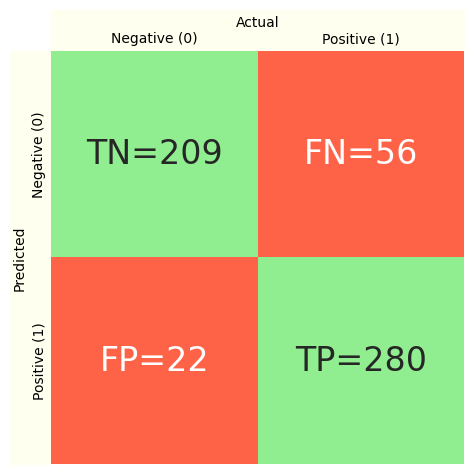

In [231]:
# Define the X & y
X = sitcom_df['posts']
y = sitcom_df['subreddit_']

#BernoulliNB
bnm_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text)),
    ('nb', BernoulliNB())
])

# Running the model & returning the trained model & scores
print('BernoulliNB with CountVectorizer')
bnm_cv_model = get_model_score(X, y, bnm_cv, True)

# MultinomialNB
mnm_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text)),
    ('nb', MultinomialNB())
])

# Running the model & returning the trained model & scores
print('MultinomialNB with CountVectorizer')
mnm_cv_model = get_model_score(X, y, mnm_cv)

# GaussianNB
sparse_to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)
gnm_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text)),
    ('sparse_to_dense', sparse_to_dense),
    ('gnb', GaussianNB())
])

# Running the model & returning the trained model & scores
print('GaussianNB with CountVectorizer')
gnm_cv_model = get_model_score(X, y, gnm_cv, True)

In [232]:
mnm_cv_model.classes_

array([0, 1])

Let's run TfidfVectorizer with all 3 Naive Bayes Model.

In [218]:
#BernoulliNB
bnm_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('nb', BernoulliNB())
])

# Running the model & returning the trained model & scores
print('BernoulliNB with TfidfVectorizer')
bnm_tf_model = get_model_score(X, y, bnm_tf)

# MultinomialNB
mnm_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('nb', MultinomialNB())
])

# Running the model & returning the trained model & scores
print('MultinomialNB with TfidfVectorizer')
mnm_tf_model = get_model_score(X, y, mnm_tf)

# GaussianNB
gnm_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('sparse_to_dense', sparse_to_dense),
    ('gnb', GaussianNB())
])

# Running the model & returning the trained model & scores
print('GaussianNB with TfidfVectorizer')
gnm_tf_model = get_model_score(X, y, gnm_tf)

BernoulliNB with TfidfVectorizer


Pipeline(steps=[('tf',
                 TfidfVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>)),
                ('nb', BernoulliNB())])

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       265
           1       0.83      0.97      0.90       302

    accuracy                           0.88       567
   macro avg       0.90      0.88      0.88       567
weighted avg       0.89      0.88      0.88       567

Accuracy (train): 0.9039334341906202
Accuracy (test): 0.8818342151675485
Cross-val-score(cv=5): 0.8373842195540309
Sensitivity(TPR): 0.9735099337748344
Specificity(TNR): 0.7773584905660378
Precision: 0.8328611898016998
-------------------------------------------------------

MultinomialNB with TfidfVectorizer


Pipeline(steps=[('tf',
                 TfidfVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>)),
                ('nb', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       265
           1       0.93      0.91      0.92       302

    accuracy                           0.92       567
   macro avg       0.92      0.92      0.92       567
weighted avg       0.92      0.92      0.92       567

Accuracy (train): 0.9863842662632375
Accuracy (test): 0.9171075837742504
Cross-val-score(cv=5): 0.8729216695254431
Sensitivity(TPR): 0.9105960264900662
Specificity(TNR): 0.9245283018867925
Precision: 0.9322033898305084
-------------------------------------------------------

GaussianNB with TfidfVectorizer


Pipeline(steps=[('tf',
                 TfidfVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>)),
                ('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x000001C351857640>)),
                ('gnb', GaussianNB())])

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       265
           1       0.83      0.83      0.83       302

    accuracy                           0.82       567
   macro avg       0.82      0.82      0.82       567
weighted avg       0.82      0.82      0.82       567

Accuracy (train): 0.9826021180030258
Accuracy (test): 0.818342151675485
Cross-val-score(cv=5): 0.7866495140080045
Sensitivity(TPR): 0.8278145695364238
Specificity(TNR): 0.8075471698113208
Precision: 0.8305647840531561
-------------------------------------------------------



Let's run CountVectorizer Bigrams with all 3 Naive Bayes Model.

In [41]:
# Define the X & y
X_bi = sitcom_df['cleaned_text']
y = sitcom_df['subreddit_']

#BernoulliNB
bnm_bi = Pipeline([
    ('bi', CountVectorizer(ngram_range=(2,2))),
    ('nb', BernoulliNB())
])

# Running the model & returning the trained model & scores
print('BernoulliNB with Bigrams')
bnm_bi_model = get_model_score(X_bi, y, bnm_bi)

# MultinomialNB
mnm_bi = Pipeline([
    ('bi', CountVectorizer(ngram_range=(2,2))),
    ('nb', MultinomialNB())
])

# Running the model & returning the trained model & scores
print('MultinomialNB with Bigrams')
mnm_bi_model = get_model_score(X_bi, y, mnm_bi)

# GaussianNB
gnm_bi = Pipeline([
    ('bi', CountVectorizer(ngram_range=(2,2))),
    ('sparse_to_dense', sparse_to_dense),
    ('gnb', GaussianNB())
])
# Running the model & returning the trained model & scores
print('GaussianNB with Bigrams')
gnm_bi_model = get_model_score(X_bi, y, gnm_bi)

BernoulliNB with Bigrams
              precision    recall  f1-score   support

           0       1.00      0.10      0.18       265
           1       0.56      1.00      0.72       302

    accuracy                           0.58       567
   macro avg       0.78      0.55      0.45       567
weighted avg       0.77      0.58      0.47       567

Accuracy (train): 0.8229954614220878
Accuracy (test): 0.5802469135802469
Sensitivity(TPR): 1.0
Specificity(TNR): 0.1018867924528302
Precision: 0.5592592592592592
-------------------------------------------------------

MultinomialNB with Bigrams
              precision    recall  f1-score   support

           0       0.83      0.69      0.76       265
           1       0.77      0.87      0.82       302

    accuracy                           0.79       567
   macro avg       0.80      0.78      0.79       567
weighted avg       0.79      0.79      0.79       567

Accuracy (train): 0.9886535552193646
Accuracy (test): 0.7901234567901234
Se

Lets tune the hyperparameters for CountVectorizer with MultinomialNB model pipe.


Estimating the maxinum number of features that can be used to tune the parameter of the pipeline:

In [53]:
# Sample a subset of your data
sample_size = 1000
random_indices = random.sample(range(len(sitcom_df['posts'])), sample_size)
sampled_X = X.iloc[random_indices]

# Calculate the maximum number of unique features from the sampled data
max_features = sampled_X.str.split().explode().nunique()
max_features
# # Add the max_features value to the pipe_params dictionary
# pipe_params['cv__max_features'] = [max_features]

9425

In [55]:
# Define the pipe parameters
pipe_params = {
    'cv__max_features': [ max_features], # 2_000, 3_000, 4_000, 5_000,
    'cv__min_df': [1], # , 2, 3
    'cv__max_df': [.9], #, .95, 1
    'nb__alpha': [0.5], # 0.01, 0.1, 1.0, 10.0
    'nb__fit_prior': [False] # True, 
}

# Define the X & y
X = sitcom_df['posts']
y = sitcom_df['subreddit_']

# MultinomialNB
mnm_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text)),
    ('nb', MultinomialNB())
])

# Run run GridSearchCV with the piped model & returning the trained model & scores
mnm_cv_grid_model = get_gridsearch_params(X, y, mnm_cv, pipe_params, 5)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=False; total time=   0.

[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=2, nb__alp

[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=2000, cv__min_df=3

[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=2, nb__al

[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=3000, cv__min_df=3, nb__a

[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=2

[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.9, cv__max_features=4000, cv__min_df=3, nb__a

[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=

[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=5000, cv__min_df=3, nb__al

[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=1, nb

[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.9, cv__max_features=9425, cv__min_df=3, nb__a

[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=1

[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=2000, cv__

[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=1

[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=3000, cv__mi

[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=1, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df

[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=2

[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=4000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=1, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__

[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=2

[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__min_df=3, nb__alpha=10.0, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=5000, cv__mi

[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=True; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=2, nb__alpha=0.1, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df

[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=0.95, cv__max_features=9425, cv__min_df=3

[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=2, nb__alpha=0.01, n

[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=2000, cv__min_df=3, nb__alpha=0.5, nb__fit_p

[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=2, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=2, nb__alpha=0.01,

[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.5, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=3000, cv__min_df=3, nb__alpha=0.5, nb__fit_

[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=10.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=1, nb__alpha=10.0, nb__

[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=4000, cv__min_df=3, nb__alpha=0.1, nb__fit_p

[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=1, nb__alpha=1.0, nb__fit_p

[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.1, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=5000, cv__min_df=3, nb__alpha=0.1, n

[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.3s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=0.5, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=1.0, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=1, nb__alpha=1.0, nb__fit_

[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=False; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=2, nb__alpha=10.0, nb__fit_prior=False; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.2s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, nb__fit_prior=True; total time=   0.1s
[CV] END cv__max_df=1, cv__max_features=9425, cv__min_df=3, nb__alpha=0.01, n

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 2250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\jinji\ana

Best Hyperparameters: {'cv__max_df': 0.9, 'cv__max_features': 9425, 'cv__min_df': 1, 'nb__alpha': 0.5, 'nb__fit_prior': False}
Best training accuracy: 0.881232132647227
Test set accuracy score for best params: 0.9065255731922398
-------------------------------------------------------

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       265
           1       0.92      0.90      0.91       302

    accuracy                           0.91       567
   macro avg       0.91      0.91      0.91       567
weighted avg       0.91      0.91      0.91       567

Sensitivity(TPR): 0.9039735099337748
Specificity(TNR): 0.909433962264151
Precision: 0.9191919191919192
-------------------------------------------------------



Next, we tune the hyperparameters for TfidfVectorizer with MultinomialNB model pipe.

In [56]:
# Define the pipe parameters
pipe_params = {
    'tf__max_features': [max_features], # 2_000, 3_000, 4_000, 5_000
    'tf__min_df': [1], # , 2, 3
    'tf__max_df': [.9], # , .95, 1
    'nb__alpha': [0.5], #0.01, 0.1, , 1.0, 10.0
    'nb__fit_prior': [True] #, False
}

# Define X & y
X = sitcom_df['posts']
y = sitcom_df['subreddit_']

# MultinomialNB
mnm_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('nb', MultinomialNB())
])

# Run run GridSearchCV with the piped model & returning the trained model & scores
mnm_tf_grid_model = get_gridsearch_params(X, y, mnm_tf, pipe_params, 5)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s


[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95,

[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=

[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=0.01, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425

[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df

[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf

[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=0.01, nb__fit_prior=False, tf__max_df=1, tf__max_feat

[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.9, tf__max_feat

[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=0.95, tf_

[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min

[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.9, tf_

[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=

[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=0.1, nb__fit_prior=False, tf__max_df=1, tf__max_features=4000

[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.9, tf__max_feat

[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=0.95, tf_

[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tf__max_df=1, tf__max_features=3000, tf__min

[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.9, tf_

[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=

[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_feature

[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=0.5, nb__fit_prior=False, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=

[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_feat

[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=0.95, tf_

[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=9425, tf__min

[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.9, tf_

[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=

[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=1.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=5000

[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.9, tf_

[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=

[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=True, tf__max_df=1, tf__max_features=4000

[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df

[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf

[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END nb__alpha=10.0, nb__fit_prior=False, tf__max_df=1, tf__max_feat

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 2250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\jinji\ana

Best Hyperparameters: {'nb__alpha': 0.5, 'nb__fit_prior': True, 'tf__max_df': 0.9, 'tf__max_features': 9425, 'tf__min_df': 1}
Best training accuracy: 0.8797284162378503
Test set accuracy score for best params: 0.9206349206349206
-------------------------------------------------------

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       265
           1       0.94      0.91      0.92       302

    accuracy                           0.92       567
   macro avg       0.92      0.92      0.92       567
weighted avg       0.92      0.92      0.92       567

Sensitivity(TPR): 0.9139072847682119
Specificity(TNR): 0.9283018867924528
Precision: 0.9355932203389831
-------------------------------------------------------



### Logistics Regression

Lets try the Logistic Regression model on all **3 Vectorizing Technique** and **Word2vec word embedding technique**

In [57]:
X = sitcom_df['posts']
# X for Bigrams
X_bi = sitcom_df['cleaned_text']
y = sitcom_df['subreddit_']

# logistic Regression with CountVectorizer
lr_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text)),
    ('lr', LogisticRegression())
])

print('Logistic Regression with CountVectorizer')
get_model_score(X, y, lr_cv)

# logistic Regression with TfidfVectorizer
lr_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('lr', LogisticRegression())
])

print('Logistic Regression with TfidfVectorizer')
get_model_score(X, y, lr_tf)

# logistic Regression with Bigrams CountVectorizer
lr_bi = Pipeline([
    ('bi', CountVectorizer(ngram_range=(2,2))),
    ('lr', LogisticRegression())
])

print('Logistic Regression with Bigrams')
get_model_score(X_bi, y, lr_bi)

Logistic Regression with CountVectorizer
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       265
           1       0.88      0.95      0.91       302

    accuracy                           0.90       567
   macro avg       0.91      0.90      0.90       567
weighted avg       0.90      0.90      0.90       567

Accuracy (train): 0.9909228441754917
Accuracy (test): 0.9012345679012346
Sensitivity(TPR): 0.9503311258278145
Specificity(TNR): 0.8452830188679246
Precision: 0.875
-------------------------------------------------------

Logistic Regression with TfidfVectorizer
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       265
           1       0.87      0.95      0.91       302

    accuracy                           0.90       567
   macro avg       0.91      0.90      0.90       567
weighted avg       0.90      0.90      0.90       567

Accuracy (train): 0.9818456883509834
Accura

Pipeline(steps=[('bi', CountVectorizer(ngram_range=(2, 2))),
                ('lr', LogisticRegression())])

Given the previous score, lets tune the hyperparameters for TfidfVectorizer with LogisticRegression model pipe.

In [58]:
# Define the pipe parameters
pipe_params = {
    'tf__max_features': [ 5_000], # 2_000, 3_000, 4_000,
    'tf__min_df': [1], # , 2, 3
    'tf__max_df': [.9], # , .95, 1
    'lr__penalty': ['l2'], # 'l1',
    'lr__C': [1.0] # np.insert(np.logspace(-3,3,7), -1, 1), # Including the default value of 1 into the array
    'lr__solver'  : [ 'liblinear'] # 'newton-cg', 'lbfgs',
}

# Define X & y
X = sitcom_df['posts']
y = sitcom_df['subreddit_']

# logistic Regression with TfidfVectorizer
lr_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('lr', LogisticRegression())
])

# Run run GridSearchCV with the piped model & returning the trained model & scores
lr_tf_model = get_gridsearch_params(X, y, lr_tf, pipe_params, 5)

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END l

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, 

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_d

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_d

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, t

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, 

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_d

[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, 

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_d

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_d

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, t

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, 

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_d

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_d

[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.001, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, 

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, t

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; tot

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_d

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.2s


[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, 

[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, t

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.4s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, 

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, t

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; tot

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_d

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.1s


[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf_

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, 

[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, t

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_d

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total ti

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; tot

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_

[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_d

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_featu

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_d

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; tot

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_fea

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_

[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=0.1, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_d

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_d

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total ti

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; tot

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_d

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_featu

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_d

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; tot

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_fea

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_d

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, 

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, t

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; tot

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; to

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_d

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.1s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_

[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, 

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   2.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   1.7s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, 

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   2.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, t

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   3.4s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   3.3s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   3.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, t

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   3.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, t

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, 

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, t

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.1s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2;

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; tot

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_d

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s


[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, 

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, t

[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   1.0s
[CV] END lr__C=10.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   1.0s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__ma

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, 

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_d

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_d

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, t

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1;

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, 

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_d

[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, 

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_d

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, t

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_d

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.7s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, t

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total ti

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, 

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_d

[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=100.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_d

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; tot

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_featur

[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=9425, tf__min_d

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.6s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=4000, tf__min_d

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; tot

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total tim

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_

[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_d

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, t

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, t

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=newton-cg, tf__max_df=1, tf__max_

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, t

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=lbfgs, tf__max_df=1, tf__max_features=3000, tf__min_df=3; tot

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__m

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, t

[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l1, lr__solver=liblinear, tf__max_df=1, tf__max_

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, t

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=newton-cg, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.8s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.7s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.7s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.7s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.7s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.7s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s


C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=2000, tf__min_df=2; 

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=lbfgs, tf__max_df=1, tf__max_features=9425, tf__min_df=3; tot

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, t

[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END lr__C=1000.0, lr__penalty=l2, lr__solver=liblinear, tf__max_df=1, tf__max_

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5200 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1400 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.pe

Best Hyperparameters: {'lr__C': 1.0, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tf__max_df': 0.9, 'tf__max_features': 5000, 'tf__min_df': 1}
Best training accuracy: 0.8736821040594627
Test set accuracy score for best params: 0.9065255731922398
-------------------------------------------------------

              precision    recall  f1-score   support

           0       0.95      0.85      0.89       265
           1       0.88      0.96      0.92       302

    accuracy                           0.91       567
   macro avg       0.91      0.90      0.91       567
weighted avg       0.91      0.91      0.91       567

Sensitivity(TPR): 0.956953642384106
Specificity(TNR): 0.8490566037735849
Precision: 0.878419452887538
-------------------------------------------------------



In [59]:
X = sitcom_df['posts']
# Call X_bi for Bigrams
X_bi = sitcom_df['cleaned_text']
y = sitcom_df['subreddit_']

# logistic Regression with CountVectorizer
lr_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text)),
    ('lr', LogisticRegression())
])

print('Logistic Regression with CountVectorizer')
get_model_score(X, y, lr_cv)

Logistic Regression with CountVectorizer
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       265
           1       0.88      0.95      0.91       302

    accuracy                           0.90       567
   macro avg       0.91      0.90      0.90       567
weighted avg       0.90      0.90      0.90       567

Accuracy (train): 0.9909228441754917
Accuracy (test): 0.9012345679012346
Sensitivity(TPR): 0.9503311258278145
Specificity(TNR): 0.8452830188679246
Precision: 0.875
-------------------------------------------------------



Pipeline(steps=[('cv',
                 CountVectorizer(analyzer=<function clean_text at 0x000001C33A1ABBE0>)),
                ('lr', LogisticRegression())])

Now we are trying Word2vec with Logistic Regression.

In [60]:
sitcom_df['clean_posts_v2'] = sitcom_df['posts'].apply(lambda x: gensim.utils.simple_preprocess(x))

X_train, X_test, y_train, y_test = train_test_split(sitcom_df['clean_posts_v2'], 
                                                    sitcom_df['subreddit_'],
                                                    test_size=0.3, 
                                                    random_state=99)

In [61]:
# Train the word2vec model
# vector_size = size of word vector. size input all dimensions that meet window param value
# window = number of words before and after the focus word that will be considered as context
# min_count = number of times word must appear in corpus in order to create a word vector
### Important - Model will only be trained on words that meet min_count so it may not learn all words as a result
w2v_model = Word2Vec(X_train, vector_size=10, window=5, min_count=2)

In [62]:
# create a list to store the average of all word vectors for each row of data
review_vect_list = []

# Iterate through each row in X train data
for index, row in X_train.iteritems():

    # Create a Word2Vec vector for each row (review) in train data 
    # By applying the W2V model on each word of each review, we get the word vector (embedding) for each word
    # Each row (review) will be represented by average of all vectors of all words in each row that model has trained on
    model_vector = (np.mean([w2v_model.wv.get_vector(token) for token in row if token in w2v_model.wv], axis=0)).tolist()

    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        review_vect_list.append(model_vector)
    else:
        review_vect_list.append([str(0) for i in range(10)])
        
word2vec_df = pd.DataFrame(review_vect_list)
word2vec_df


C:\Users\jinji\AppData\Local\Temp\ipykernel_11360\3005331301.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in X_train.iteritems():
C:\Users\jinji\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jinji\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0         1         2         3         4         5         6  \
0     1.149186 -0.551641  1.523997  0.289757  0.309768  0.026863  1.893738   
1     1.093218 -0.536564  1.528321  0.306002  0.365744  0.025023   1.91097   
2     1.013882 -0.491256  1.322559  0.249253  0.278762  0.005512  1.669361   
3      0.69546 -0.337639  0.981189   0.18024  0.230509  0.035722  1.265984   
4     1.153957 -0.557375   1.54595  0.344484  0.343588  0.005706  1.974255   
...        ...       ...       ...       ...       ...       ...       ...   
1317  1.078897 -0.511425  1.447794  0.292263  0.310727  0.034882   1.80496   
1318  0.769966 -0.358194  1.047187  0.197396   0.18527  0.055797   1.19648   
1319  1.162721 -0.557109  1.489495  0.246849   0.30444  0.025809  1.836346   
1320   1.00277 -0.503092   1.37792  0.294761  0.284899 -0.018233  1.715763   
1321  1.386518 -0.686918  1.866188   0.38371  0.383388  0.002253  2.383497   

             7         8         9  
0     0.945085 -1.931269 -0.850974  
1     0.934642 -1.925516 -0.885155  
2     0.828109 -1.686088 -0.761482  
3      0.56657 -1.228312 -0.505405  
4     0.937691 -1.983669 -0.907711  
...        ...       ...       ...  
1317  0.882886 -1.828889 -0.809481  
1318  0.600571   -1.2571 -0.550566  
1319  0.909264 -1.849573 -0.794356  
1320  0.886414 -1.778049 -0.817013  
1321  1.155367 -2.348778 -1.056957  

[1322 rows x 10 columns]

In [63]:
# Instantiate the model
clf_model_word2vec = LogisticRegression(max_iter=200)

# Fit model
clf_model_word2vec.fit(word2vec_df, y_train)

LogisticRegression(max_iter=200)

In [64]:
test_features_word2vec = []

for index, row in X_test.items():
    model_vector = (np.mean([w2v_model.wv.get_vector(token) for token in row if token in w2v_model.wv], axis=0)).tolist()

    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(10)]))
        
        
test_predictions_word2vec = clf_model_word2vec.predict(test_features_word2vec)

print(classification_report(y_test, test_predictions_word2vec))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62       287
           1       0.60      0.59      0.60       280

    accuracy                           0.61       567
   macro avg       0.61      0.61      0.61       567
weighted avg       0.61      0.61      0.61       567



C:\Users\jinji\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jinji\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Random Forest Classifier

Lets try running Random Forest Classifier!

In [65]:
# Define X & y
X = sitcom_df['posts']
# X for Bigrams
X_bi = sitcom_df['cleaned_text']
y = sitcom_df['subreddit_']

# logistic Regression with CountVectorizer
rfc_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text)),
    ('rfc', RandomForestClassifier(random_state=42))
])

# Running the model & returning the trained model & scores
print('Count Vectorizer with Random Forest Classifier')
get_model_score(X, y, rfc_cv)

# logistic Regression with TfidfVectorizer
rfc_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('rfc', RandomForestClassifier(random_state=42))
])

# Running the model & returning the trained model & scores
print('Tfidf Vectorizer with Random Forest Classifier')
get_model_score(X, y, rfc_tf)

# logistic Regression with Bigrams CountVectorizer
rfc_bi = Pipeline([
    ('bi', CountVectorizer(ngram_range=(2,2))),
    ('rfc', RandomForestClassifier(random_state=42))
])

# Running the model & returning the trained model & scores
print('Count Vectorizer with Logistic Regression with Bigrams')
get_model_score(X_bi, y, rfc_bi)

Count Vectorizer with Random Forest Classifier
              precision    recall  f1-score   support

           0       0.93      0.85      0.88       265
           1       0.87      0.94      0.91       302

    accuracy                           0.90       567
   macro avg       0.90      0.89      0.89       567
weighted avg       0.90      0.90      0.90       567

Accuracy (train): 1.0
Accuracy (test): 0.8959435626102292
Sensitivity(TPR): 0.9403973509933775
Specificity(TNR): 0.8452830188679246
Precision: 0.8738461538461538
-------------------------------------------------------

Tfidf Vectorizer with Random Forest Classifier
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       265
           1       0.86      0.94      0.90       302

    accuracy                           0.89       567
   macro avg       0.89      0.88      0.88       567
weighted avg       0.89      0.89      0.88       567

Accuracy (train): 1.0
Accuracy (t

Pipeline(steps=[('bi', CountVectorizer(ngram_range=(2, 2))),
                ('rfc', RandomForestClassifier(random_state=42))])

Results were not super! Lets try tuning the hyperparameters for the model.
<br> *Note: This will take a long time to run (About 30 min)*

In [66]:
# Define the pipe parameters
pipe_params = {
    'tf__max_features': [2_000], # 3_000, 4_000, 5_000
    'tf__min_df': [1], # 2, 3
    'tf__max_df': [.9], # .95, 1
    'rfc__n_estimators': [100], # 50 , 150, 200, 300
    'rfc__max_depth': [None], # 4,5,6,7,8
    'rfc__max_features': ['sqrt'] #'log2'
    
}

# Define X & y
X = sitcom_df['posts']
y = sitcom_df['subreddit_']

# logistic Regression with TfidfVectorizer
rfc_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text)),
    ('rfc', RandomForestClassifier(random_state=42))
])

# Running the model & returning the trained model & scores
rfc_tf_model = get_gridsearch_params(X, y, rfc_tf, pipe_params, 5)


Fitting 5 folds for each of 2700 candidates, totalling 13500 fits
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estima

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; tota

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   1.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   1.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   1.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.4s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   1.4s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   1.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; tota

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; tot

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__m

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=4, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; tota

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.4s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1;

[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; tota

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=

[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=5, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; tota

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=

[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; tota

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; tot

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=6, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; tota

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; tota

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=3000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.4s

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=2000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=5000, tf__

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   1.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=9425, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__mi

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; tota

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.4s

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__

[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=7, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; tota

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.4s

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=1;

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total ti

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.6s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.5s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.4s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=

[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; tota

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.5s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.6s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.1s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.8s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   0.9s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=4000, tf__

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=

[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=8, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=500

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=0.95, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=50, tf__max_df=1, tf__max_features=9425, tf__min_df=

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   2.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   2.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=5000, tf__min_df=2; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.6s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=4000, tf__min_df=1; total time=   1.5s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=2000, tf__

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   2.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=100, tf__max_df=1, tf__max_features=9425, tf__

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   3.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   3.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   3.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   3.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=2000, tf__

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   2.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   2.7s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   2.6s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   2.5s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   2.5s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=150, tf__max_df=1, tf__max_features=9425, tf__

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   2.6s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   2.5s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   2.4s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=5000, tf__min_df=1; total time=   4.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   2.4s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   2.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=3000, tf__min_df=3; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   2.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   2.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   2.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=2000, tf__

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   3.6s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__min_df=1; total time=   3.5s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=200, tf__max_df=1, tf__max_features=9425, tf__

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   4.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   4.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   4.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   3.7s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   3.6s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=4000, tf__min_df=3; total time=   4.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   4.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   4.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   4.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   3.9s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   4.2s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   4.7s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   3.1s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   3.0s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   3.4s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   3.7s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   3.5s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   3.5s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=2

[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=sqrt, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.9, tf__max_features=400

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=3000, tf__min_df=2; total time=   1.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   0.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=2000, tf__min_df=1; total time=   0.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=20

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=50, tf__max_df=1, tf__max_features=5000, tf__min_df=

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   1.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.4s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.5s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.4s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.4s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   1.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=100, tf__max_df=1, tf__max_features=5000, tf__

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.5s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_features=4000, tf__min_df=2; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=3000, tf__min_df=1; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.5s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   1.5s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__max_features=9425, tf__min_df=3; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__min_df=2; total time=   0.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=150, tf__max_df=1, tf__max_features=5000, tf__

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   1.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_features=4000, tf__min_df=1; total time=   2.5s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   1.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=2000, tf__min_df=3; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   3.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   2.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   2.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__max_features=9425, tf__min_df=2; total time=   2.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.4s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   2.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   2.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=200, tf__max_df=1, tf__max_features=5000, tf__

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=2; total time=   3.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   2.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   2.8s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   3.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   2.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_features=3000, tf__min_df=3; total time=   2.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.9, tf__max_featu

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=1; total time=   3.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   4.0s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   3.7s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   3.4s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   3.6s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=2000, tf__min_df=2; total time=   3.5s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=5000, tf__min_df=3; total time=   3.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   5.4s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   5.9s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   5.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   5.5s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__max_features=9425, tf__min_df=1; total time=   5.1s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=0.95, tf__ma

[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=4000, tf__min_df=3; total time=   0.3s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__min_df=1; total time=   3.2s
[CV] END rfc__max_depth=None, rfc__max_features=log2, rfc__n_estimators=300, tf__max_df=1, tf__max_features=5000, tf__

C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3000 fits failed out of a total of 13500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3000 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\jinji\anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\jinji\

Best Hyperparameters: {'rfc__max_depth': None, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 100, 'tf__max_df': 0.9, 'tf__max_features': 2000, 'tf__min_df': 1}
Best training accuracy: 0.8752001143510577
Test set accuracy score for best params: 0.8977072310405644
-------------------------------------------------------

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       265
           1       0.85      0.98      0.91       302

    accuracy                           0.90       567
   macro avg       0.91      0.89      0.90       567
weighted avg       0.91      0.90      0.90       567

Sensitivity(TPR): 0.9768211920529801
Specificity(TNR): 0.8075471698113208
Precision: 0.8526011560693642
-------------------------------------------------------



In [67]:
rfc_tf_model.classes_

array([0, 1])

### Fine Tuning of Best Models

The following models and parameters are chosen based on the better performing GridSearch results. (TBC: To better define the criteria)

[CountVectorizer with MultinomialNB](#CountVectorizer-with-MultinomialNB) <br>
[TfidfVectorizer with MultinomialNB](#MultinomialNB-with-TfidfVectorizer) <br>
[TfidfVectorizer with LogisticRegression](#TfidfVectorizer-with-LogisticRegression) 

In [173]:
# Define X & y
X = sitcom_df['posts']
y = sitcom_df['subreddit_']

In [177]:
# CountVectorizer with MultinomialNB
mnm_cv = Pipeline([
    ('cv', CountVectorizer(analyzer=clean_text, max_df=0.9, max_features=max_features, min_df=1)),
    ('nb', MultinomialNB(alpha=0.5, fit_prior=False))
])

# Running the model & returning the trained model & scores
print('MultinomialNB with CountVectorizer')
mnm_cv_model = get_model_score(X, y, mnm_cv)

MultinomialNB with CountVectorizer
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       265
           1       0.92      0.90      0.91       302

    accuracy                           0.91       567
   macro avg       0.91      0.91      0.91       567
weighted avg       0.91      0.91      0.91       567

Accuracy (train): 0.970499243570348
Accuracy (test): 0.9065255731922398
Cross-val-score(cv=5): 0.881232132647227
Sensitivity(TPR): 0.9039735099337748
Specificity(TNR): 0.909433962264151
Precision: 0.9191919191919192
-------------------------------------------------------



In [179]:
# TfidfVectorizer with MultinomialNB
mnm_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text, max_df=0.9, max_features=max_features, min_df=1)),
    ('nb', MultinomialNB(alpha=0.5, fit_prior=True))
])

print('MultinomialNB with TfidfVectorizer')
mnm_tf_model = get_model_score(X, y, mnm_tf)

MultinomialNB with TfidfVectorizer
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       265
           1       0.94      0.91      0.92       302

    accuracy                           0.92       567
   macro avg       0.92      0.92      0.92       567
weighted avg       0.92      0.92      0.92       567

Accuracy (train): 0.9886535552193646
Accuracy (test): 0.9206349206349206
Cross-val-score(cv=5): 0.8797284162378503
Sensitivity(TPR): 0.9139072847682119
Specificity(TNR): 0.9283018867924528
Precision: 0.9355932203389831
-------------------------------------------------------



In [181]:
# TfidfVectorizer with logistic Regression 
lr_tf = Pipeline([
    ('tf', TfidfVectorizer(analyzer=clean_text, max_df=0.9, max_features=5000, min_df=1)),
    ('lr', LogisticRegression(C= 1.0, penalty='l2', solver='liblinear'))
])

print('Logistic Regression with TfidfVectorizer')
get_model_score(X, y, lr_tf)

Logistic Regression with TfidfVectorizer
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       265
           1       0.88      0.96      0.92       302

    accuracy                           0.91       567
   macro avg       0.91      0.90      0.91       567
weighted avg       0.91      0.91      0.91       567

Accuracy (train): 0.9795763993948563
Accuracy (test): 0.9065255731922398
Cross-val-score(cv=5): 0.8736821040594627
Sensitivity(TPR): 0.956953642384106
Specificity(TNR): 0.8490566037735849
Precision: 0.878419452887538
-------------------------------------------------------



Pipeline(steps=[('tf',
                 TfidfVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>,
                                 max_df=0.9, max_features=5000)),
                ('lr', LogisticRegression(solver='liblinear'))])

#### Integrating the additional features into dataset for modelling `len_posts` and `num_emojis`


In [202]:
sitcom_df_x

posts  subreddit_  \
0     Official Discord Server for r/bigbangtheory! H...           0   
1     New 'Big Bang Theory' Spinoff in Development a...           0   
2     Why did Jim Parsons want to move on from the s...           0   
3                               Sing Soft Wookie To Me            0   
4     Anyone here relate to a certain character and ...           0   
...                                                 ...         ...   
1884                            cheat day diet options            1   
1885  Wife got me this shirt out of the blue, though...           1   
1886                Some say that makes Zeus my Dad...            1   
1887  If you had to guess, which lines would you say...           1   
1888                      New “Jake Approves” template            1   

                                           cleaned_text  \
0     official discord server rbigbangtheory hi made...   
1     new big bang theory spinoff development hbo ma...   
2     jim parson want move show character continues ...   
3                                     sing soft wookie    
4     anyone relate certain character raj socially i...   
...                                                 ...   
1884                             cheat day diet option    
1885       wife got shirt blue thought folk would like    
1886                                 say make zeus dad    
1887  guess line would say improvised partially impr...   
1888                        new jake approves template    

                                        cleaned_text_v2  len_posts emojis  \
0     official discord server rbigbangtheory hi made...        385     []   
1     new big bang theory spinoff development hbo ma...         73     []   
2     jim parson want move continues produce narrate...        113     []   
3                                     sing soft wookie          23     []   
4     anyone relate certain raj socially inept espec...        138     []   
...                                                 ...        ...    ...   
1884                             cheat day diet option          23     []   
1885            wife got shirt blue thought folk would          72     []   
1886                                 say make zeus dad          35     []   
1887  guess line would say improvised partially impr...        119     []   
1888                        new jake approves template          29     []   

      num_emojis  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
1884           0  
1885           0  
1886           0  
1887           0  
1888           0  

[1889 rows x 7 columns]

In [219]:
X = sitcom_df_x[['posts','len_posts', 'num_emojis']]
y = sitcom_df_x['subreddit_']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X.dtypes

posts         object
len_posts      int64
num_emojis     int64
dtype: object

In [223]:
preprocess = ColumnTransformer(
    [('description_tfidf', TfidfVectorizer(analyzer=clean_text, max_df=0.9, max_features=max_features, min_df=1), 'posts')],
    remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocess),
    ('nb', MultinomialNB(alpha=0.5, fit_prior=True))
])

# pipeline.fit(X_train, y_train)
# display(pipeline)

# # Calculate the scores
# score = pipeline.score(X_test, y_test)
# score

print('TfidfVectorizer with MultinomialNB')
get_model_score(X, y, pipeline)

TfidfVectorizer with MultinomialNB


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('description_tfidf',
                                                  TfidfVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>,
                                                                  max_df=0.9,
                                                                  max_features=9425),
                                                  'posts')])),
                ('nb', MultinomialNB(alpha=0.5))])

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       265
           1       0.92      0.74      0.82       302

    accuracy                           0.83       567
   macro avg       0.84      0.83      0.83       567
weighted avg       0.84      0.83      0.82       567

Accuracy (train): 0.9288956127080181
Accuracy (test): 0.8253968253968254
Cross-val-score(cv=5): 0.7957804459691252
Sensitivity(TPR): 0.7350993377483444
Specificity(TNR): 0.9283018867924528
Precision: 0.921161825726141
-------------------------------------------------------



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('description_tfidf',
                                                  TfidfVectorizer(analyzer=<function clean_text at 0x000001C34FC185E0>,
                                                                  max_df=0.9,
                                                                  max_features=9425),
                                                  'posts')])),
                ('nb', MultinomialNB(alpha=0.5))])

#### Exporting Models

In [161]:
import pickle

# save the models to disk
filename = 'mnm_tf_model.pkl'
pickle.dump(mnm_tf_model, open(filename, 'wb'))

#### Final Analysis

Feature Importance (Debugging in progress)

In [184]:
# <font color="red">FEATURE IMPORTANCES</font>

best_model_feature_names=mnm_tf_model.best_estimator_[0].get_feature_names_out()

best_model_feature_names.shape

# feature log probabilities for class 1
best_model_class1=mnm_tf_grid_model.best_estimator_.steps[1][1].feature_log_prob_[1]

best_model_class1.shape

best_model_class1_df=pd.DataFrame(data=[best_model_class1], columns=best_model_feature_names)

# feature log probabilities for class 0
best_model_class0=mnm_tf_grid_model.best_estimator_.steps[1][1].feature_log_prob_[0]

best_model_class0_df=pd.DataFrame(data=[best_model_class0], columns=best_model_feature_names)

# calc the difference between class 1 and class 0 coefs
best_model_df = best_model_class1_df - best_model_class0

best_model_df.max().sort_values(ascending=False).head(20)
# if positive, more liklely to be in be class 1 + the bigger the magnitude the more predictive

best_model_df.max().sort_values(ascending=False).tail(20)

AttributeError: 'Pipeline' object has no attribute 'best_estimator_'

## Sentiment Analysis

In [60]:
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [61]:
sentiment_df = sitcom_df.copy()

In [62]:
def scores(s):
    sia = SIA()
    pol_score = sia.polarity_scores(s['posts'])
    return s.append(pd.Series(list(pol_score.values()), index=pol_score.keys()))

In [63]:
sentiment_df = sentiment_df.apply(scores, axis=1)
sentiment_df

posts  subreddit_  \
0     Official Discord Server for r/bigbangtheory! H...           0   
1     New 'Big Bang Theory' Spinoff in Development a...           0   
2     Unpopular opinion but I think Amy is the most ...           0   
3               One of my favorite lines from Leonard.            0   
4     I just realized an easter egg from season 1 pr...           0   
...                                                 ...         ...   
1883  What's the song that plays while Jake is ridin...           1   
1884                      Least favourite running gag?            1   
1885  Rosas voice Every time I finish the show and r...           1   
1886  I know it's been said before but they need a s...           1   
1887  Went to Brooklyn, met the Vulture! Okay so wil...           1   

                                           cleaned_text  \
0     official discord server rbigbangtheory hi made...   
1     new big bang theory spinoff development hbo ma...   
2     unpopular opinion think amy intelligent person...   
3                            one favorite line leonard    
4     realized easter egg season 1 predicts introduc...   
...                                                 ...   
1883  whats song play jake riding horse episode 13 s...   
1884                       least favourite running gag    
1885  rosa voice every time finish show rewatch get ...   
1886  know said need standalone show httpspreviewred...   
1887  went brooklyn met vulture okay post photo tomo...   

                                        cleaned_text_v2  \
0     official discord server rbigbangtheory hi made...   
1     new big bang theory spinoff development hbo ma...   
2     unpopular opinion think amy intelligent person...   
3                            one favorite line leonard    
4     realized easter egg season 1 predicts introduc...   
...                                                 ...   
1883  whats song play jake riding horse 13 season 7 ...   
1884                       least favourite running gag    
1885  rosa voice every time finish rewatch get surpr...   
1886  know said need standalone httpspreviewreddit41...   
1887  went brooklyn met vulture okay post photo tomo...   

                                         clean_posts_v2    neg    neu    pos  \
0     [official, discord, server, for, bigbangtheory...  0.127  0.690  0.183   
1     [new, big, bang, theory, spinoff, in, developm...  0.000  1.000  0.000   
2     [unpopular, opinion, but, think, amy, is, the,...  0.041  0.738  0.221   
3         [one, of, my, favorite, lines, from, leonard]  0.000  0.667  0.333   
4     [just, realized, an, easter, egg, from, season...  0.000  0.879  0.121   
...                                                 ...    ...    ...    ...   
1883  [what, the, song, that, plays, while, jake, is...  0.000  0.839  0.161   
1884                   [least, favourite, running, gag]  0.444  0.556  0.000   
1885  [rosas, voice, every, time, finish, the, show,...  0.000  0.909  0.091   
1886  [know, it, been, said, before, but, they, need...  0.000  1.000  0.000   
1887  [went, to, brooklyn, met, the, vulture, okay, ...  0.069  0.836  0.095   

      compound  
0       0.5526  
1       0.0000  
2       0.9799  
3       0.4588  
4       0.9439  
...        ...  
1883    0.7550  
1884   -0.3400  
1885    0.2263  
1886    0.0000  
1887    0.7500  

[1888 rows x 9 columns]

In [64]:
sent_summary = sentiment_df.groupby('subreddit_')['neg', 'neu', 'pos', 'compound'].mean()
display(sent_summary)

neg       neu       pos  compound
subreddit_                                        
0           0.057077  0.818608  0.122119  0.242787
1           0.057000  0.805459  0.137548  0.210600

In [65]:
sent_summary = sent_summary.T.reset_index()
sent_summary.index.name = None
sent_summary = sent_summary.rename(columns={'index': 'sentiment', 0:'bigbangtheory',1:'brooklynninenine'})
sent_summary

subreddit_ sentiment  bigbangtheory  brooklynninenine
0                neg       0.057077          0.057000
1                neu       0.818608          0.805459
2                pos       0.122119          0.137548
3           compound       0.242787          0.210600

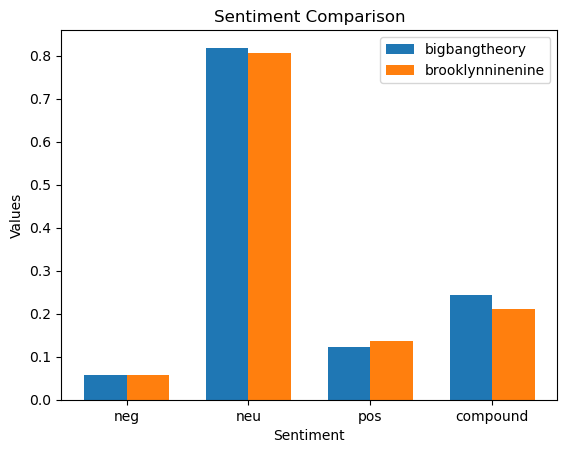

In [66]:
# Set the x-axis values
x = np.arange(4)

# Set the width of each bar
width = 0.35

# Plot the bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, sent_summary['bigbangtheory'], width, label='bigbangtheory')
bar2 = ax.bar(x + width/2, sent_summary['brooklynninenine'], width, label='brooklynninenine')

# Add labels, title, and legend
ax.set_xlabel('Sentiment')
ax.set_ylabel('Values')
ax.set_title('Sentiment Comparison')
ax.set_xticks(x)
ax.set_xticklabels(sent_summary['sentiment'])
ax.legend()

# Show the plot
plt.show()

brooklynninenine posts have greater positive sentiments as compared to bigbangtheory. However, bigbangtheory posts have greater overall sentiment intensity (compound value).

In [242]:
from emosent import get_emoji_sentiment_rank
get_emoji_sentiment_rank('😂')

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 180: character maps to <undefined>